In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import imageio
import os

import act_max_util as amu

from autoencoder import *
from solver import *
from model_utils import *

In [2]:
# MNIST normalisation
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(len(mnist_train) * 0.8)
validation_size = len(mnist_train) - train_size
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [train_size, validation_size])

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
validation_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [3]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

In [4]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

In [5]:
size_ls = [4, 4, 4, 4, 4, 10,
        10, 10, 10, 10, 16, 16,
        16, 16, 16, 16, 16, 24,
        24, 24, 24, 24, 24, 24, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32]

In [6]:
# For all different models
dae_rf_matrices = []

for iteration in range(1,2):
    # For all different epochs
    dae_rf_matrix = []
    
    for epoch in tqdm(range(50)):
        data = torch.randn(28, 28)
        data = data.unsqueeze(0)
        input = data.view(data.size(0), -1)
        input.requires_grad_(True)

        dae = load_model(f'/home/david/mnist_model/dae/{iteration}', 'dae', epoch)
        
        layer_name = 'bottle_neck'
        sae_activation_dictionary = {}
        dae_activation_dictionary = {}

        dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))


        dae_rf_ls = []
        for i in range(size_ls[epoch]):
            output = amu.act_max(network=dae,
                            input=input,
                            layer_activation=dae_activation_dictionary,
                            layer_name=layer_name,
                            unit=i,
                            steps=steps,
                            alpha=alpha,
                            verbose=verbose,
                            L2_Decay=L2_Decay,
                            Gaussian_Blur=Gaussian_Blur,
                            Norm_Crop=Norm_Crop,
                            Contrib_Crop=Contrib_Crop,
                            )
            dae_rf_ls.append(output.detach().numpy())
        dae_rf_ls = np.array(dae_rf_ls).squeeze()

        dae_rf_matrix.append(dae_rf_ls)

    dae_rf_matrices.append(dae_rf_matrix)

  0%|          | 0/50 [00:00<?, ?it/s]/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torc

In [7]:
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

def pad_matrices(model_ls, target_dim=32):
    padded_data = []
    for epoch_ls in model_ls:
        padded_epoch_ls = []
        for neuron_ls in epoch_ls:
            padding_array = np.zeros((target_dim - len(neuron_ls), 784))
            padded_neuron_ls = np.vstack([neuron_ls, padding_array])
            padded_epoch_ls.append(padded_neuron_ls)
        padded_data.append(padded_epoch_ls)
    return np.array(padded_data)

In [8]:
dae_rf_matrices = pad_matrices(dae_rf_matrices)
dae_rf_matrices.shape

(1, 50, 32, 784)

In [9]:
num_models = 1
num_epochs = 50
num_neurons = 32

dae_angles_matrix = np.zeros((num_models, num_neurons, num_epochs-1))

for model in range(num_models):
    for epoch in range(num_epochs-1):
        for neuron in range(num_neurons):
            angle = cosine_angle_between_pcs(dae_rf_matrices[model][epoch][neuron], dae_rf_matrices[model][epoch + 1][neuron])
            dae_angles_matrix[model, neuron, epoch] = angle

dae_angles_matrix = np.array(dae_angles_matrix)

dae_average_angles = np.mean(dae_angles_matrix, axis=0)

/tmp/ipykernel_11742/719229213.py:5: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [10]:
highlighted_non_computable_angles = dae_average_angles.copy()

In [11]:
for i in range(highlighted_non_computable_angles.shape[0]):
    for j in range(highlighted_non_computable_angles.shape[1] - 1):
        if np.isnan(highlighted_non_computable_angles[i, j]) and not np.isnan(highlighted_non_computable_angles[i, j + 1]):
            highlighted_non_computable_angles[i, j] = 100

In [12]:
mask = highlighted_non_computable_angles == 100
non_computable_cells = np.where(mask, 1, np.nan)

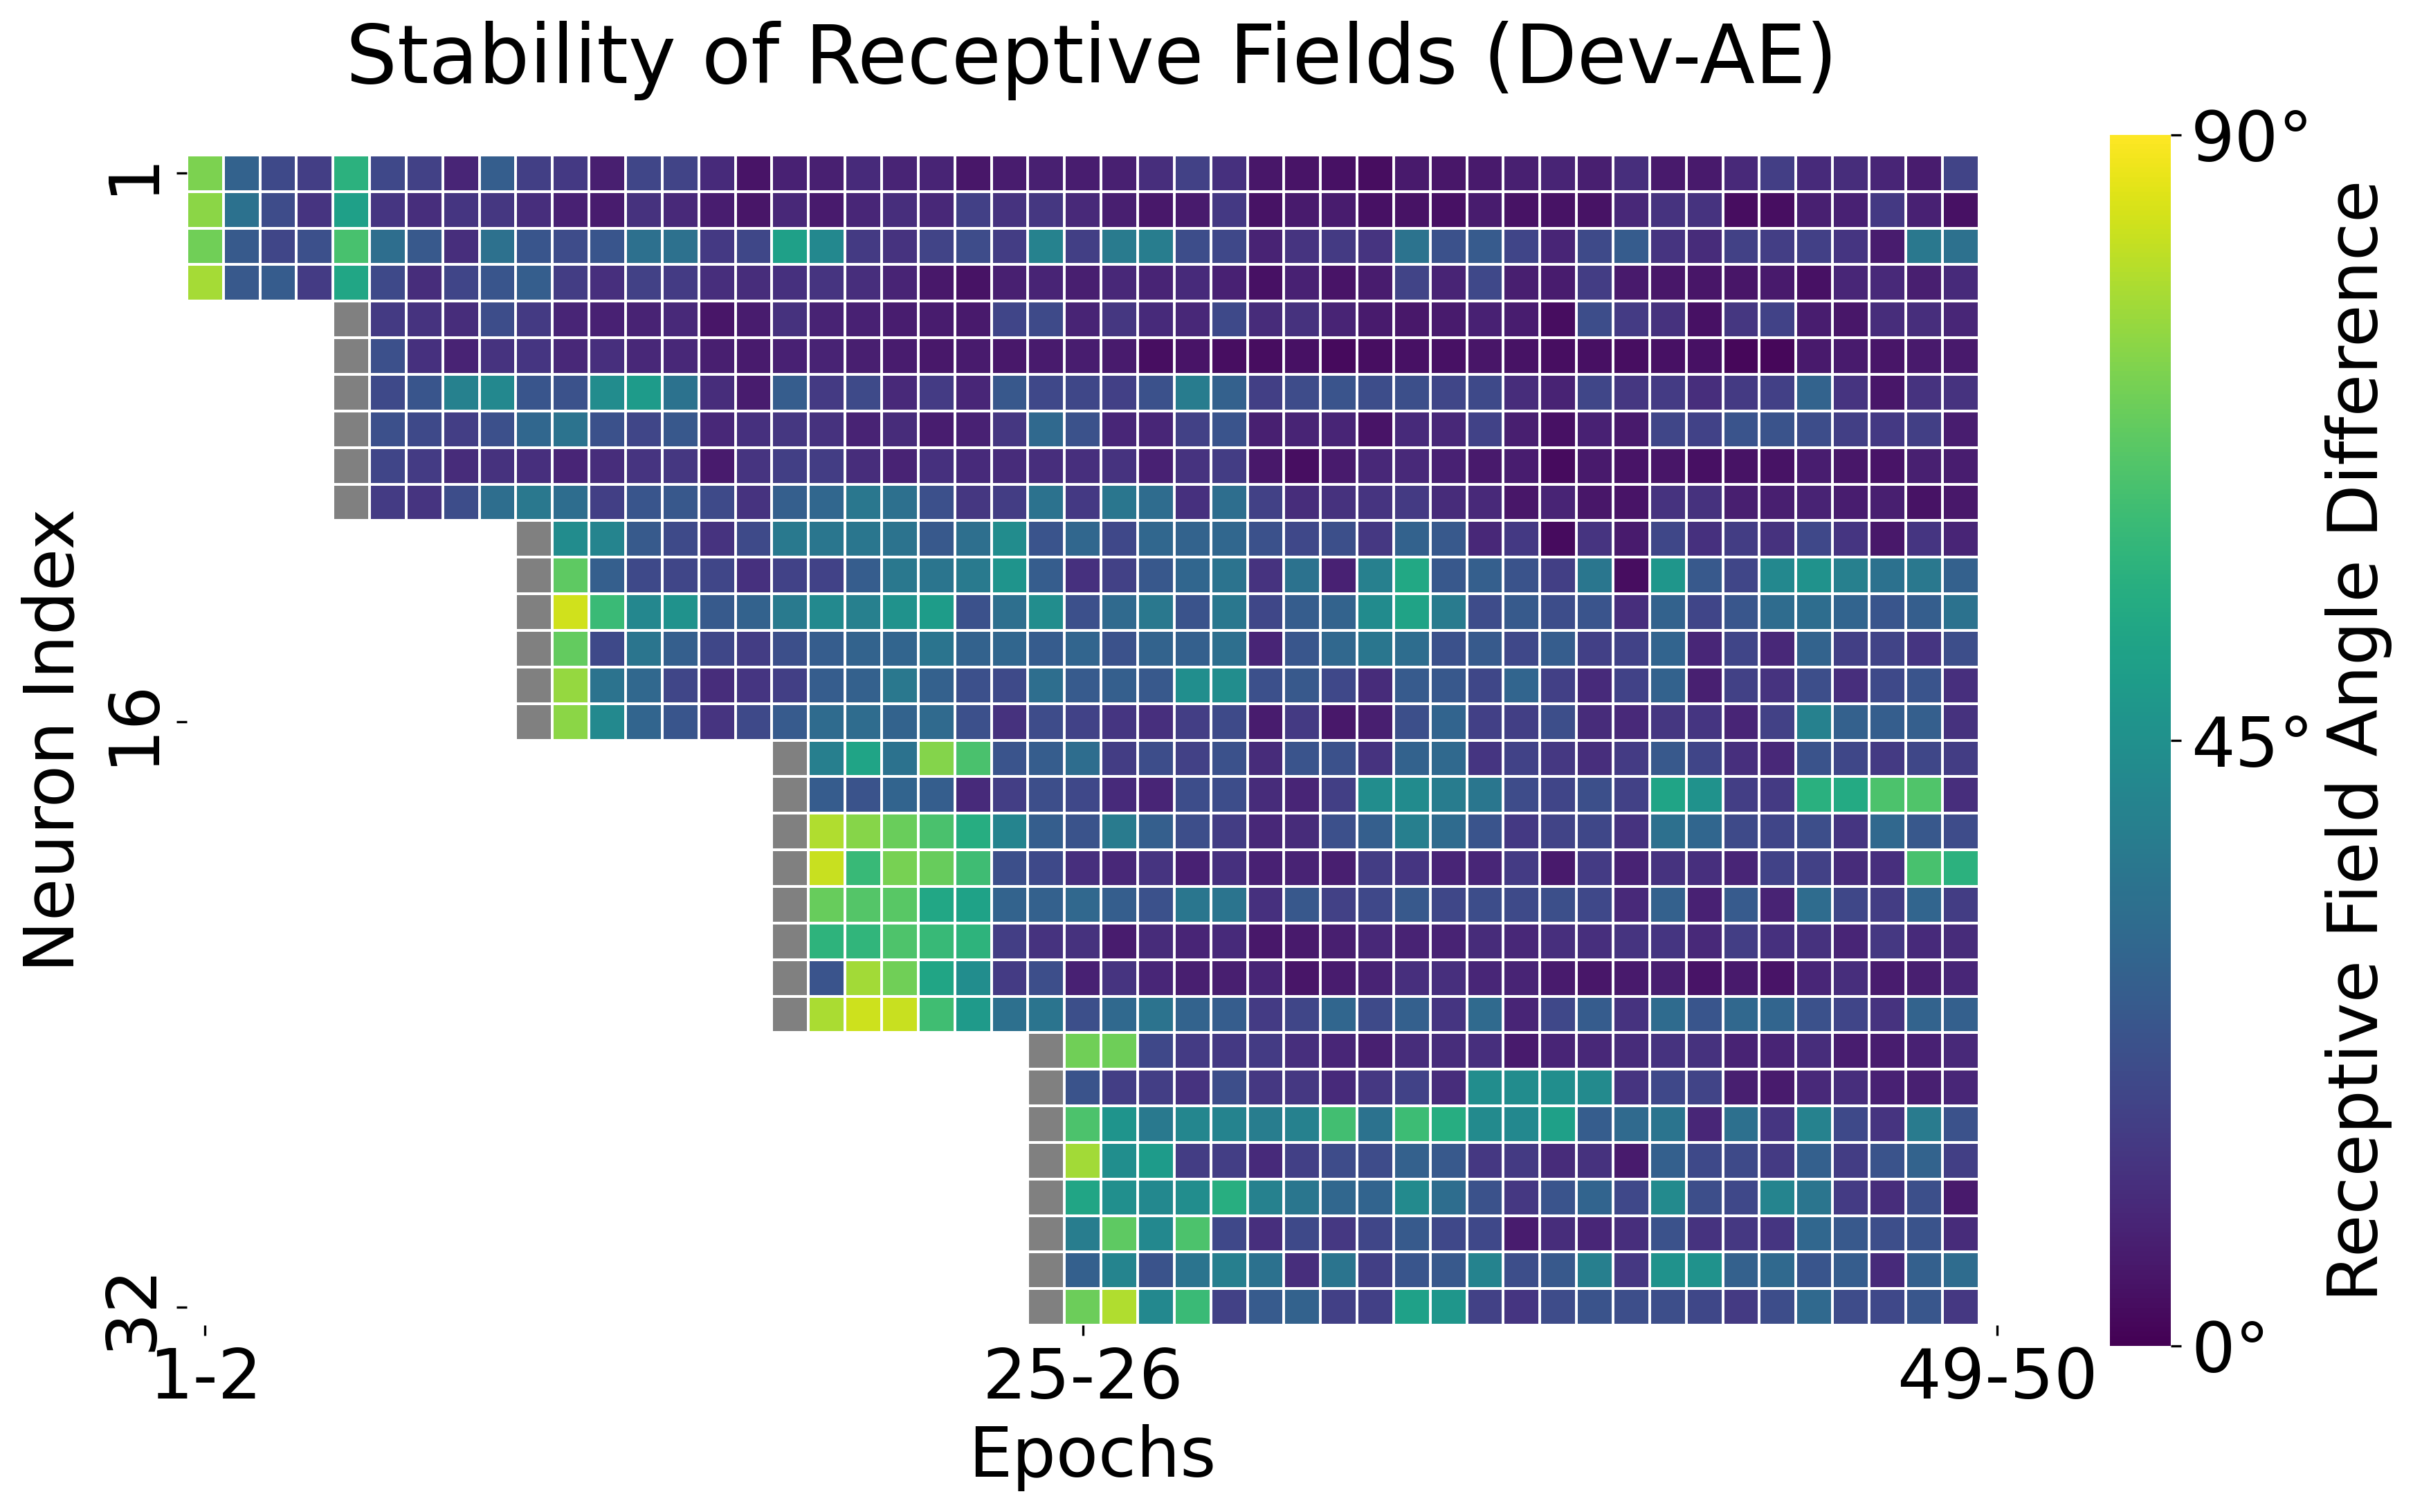

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    dae_average_angles[:, :50],
    cmap="viridis",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
    square=True,
)

cmap_grey = ListedColormap(['grey'])
sns.heatmap(
    non_computable_cells[:, :50],
    cmap=cmap_grey,
    cbar=False,
    alpha=1,
    linewidths=0.5,
    square=True,
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("Receptive Field Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

ax.set_title("Stability of Receptive Fields (Dev-AE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Neuron Index", fontsize=24)

plt.tight_layout()
plt.show()

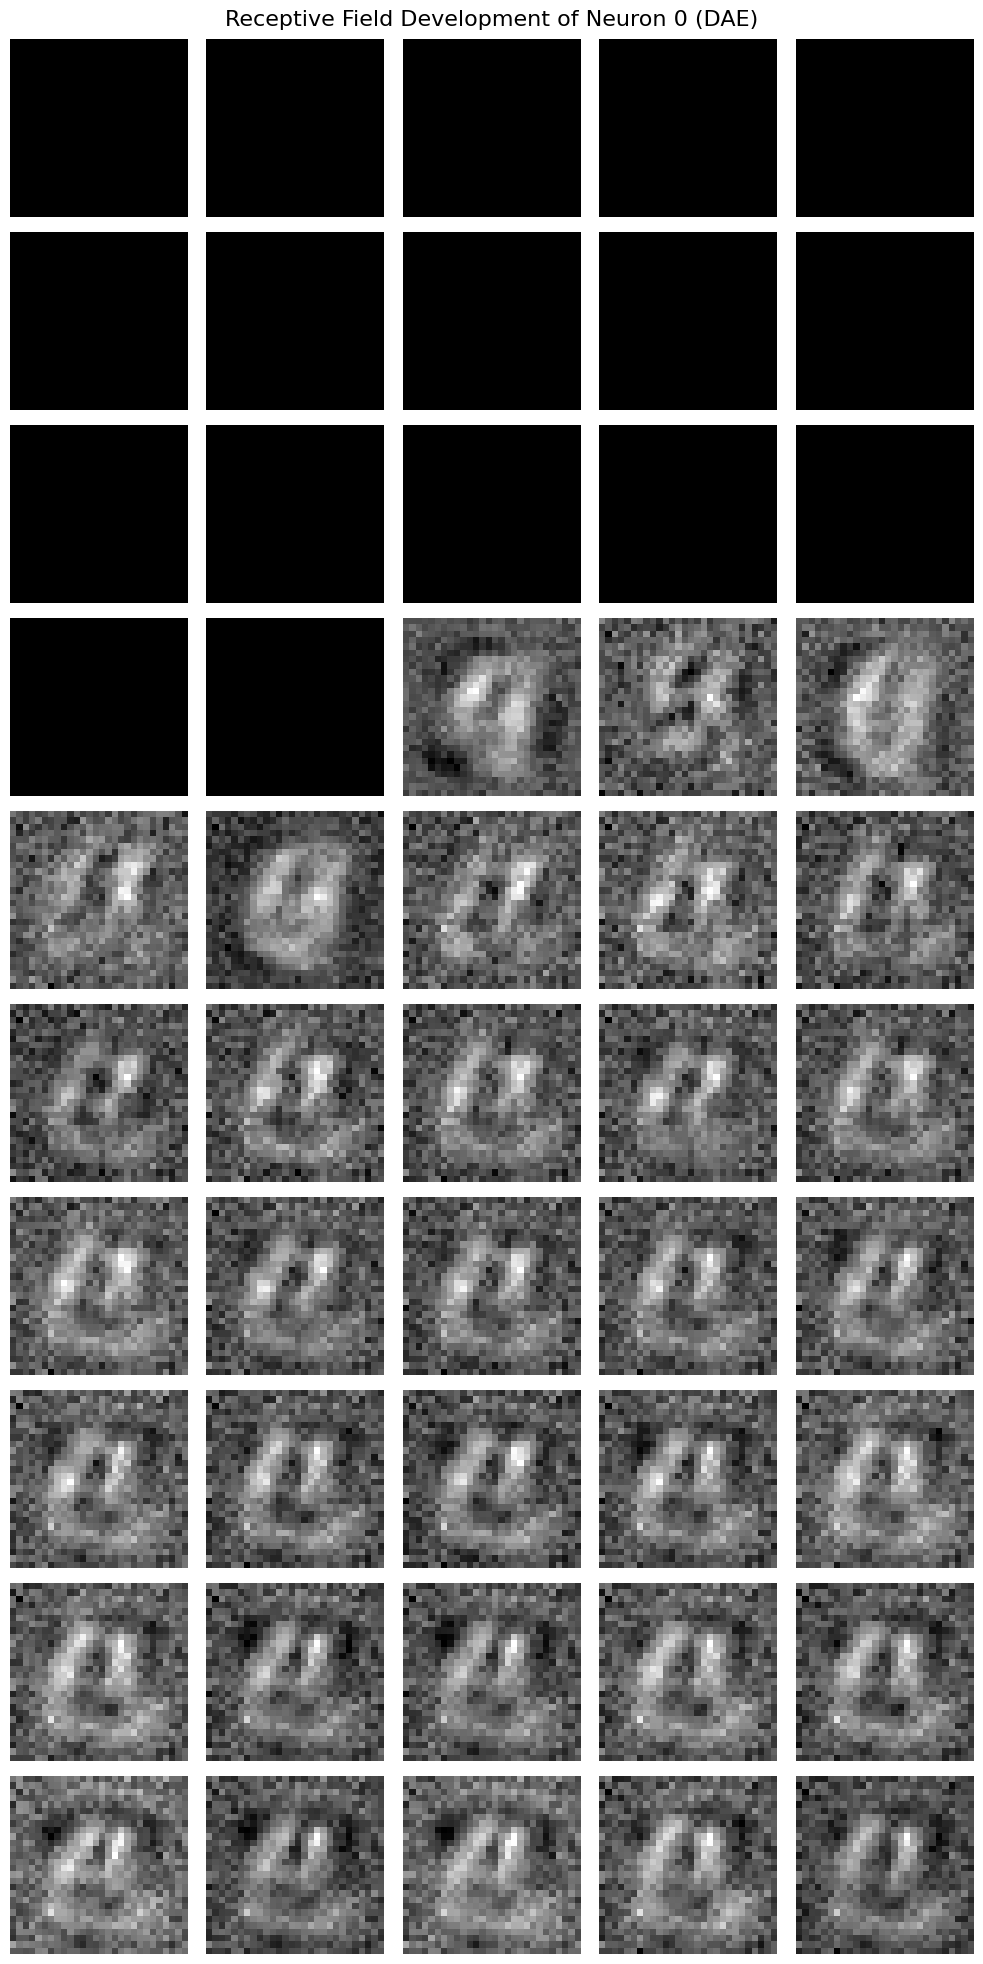

In [28]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
axes = axes.ravel()

for i in range(50):
    axes[i].imshow(dae_rf_matrices[0][i][20].reshape(28, 28), cmap='binary_r')
    axes[i].axis('off')

fig.suptitle("Receptive Field Development of Neuron 0 (DAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

In [19]:
# For all different models
sae_rf_matrices = []

for iteration in range(1):
    # For all different epochs
    sae_rf_matrix = []
    
    for epoch in tqdm(range(50)):
        data = torch.randn(28, 28)
        data = data.unsqueeze(0)
        input = data.view(data.size(0), -1)
        input.requires_grad_(True)

        sae = load_model(f'/home/david/mnist_model/sae/{iteration}', 'sae', epoch)
        
        layer_name = 'bottle_neck'
        sae_activation_dictionary = {}

        sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))

        sae_rf_ls = []
        for i in range(32):
            output = amu.act_max(network=sae,
                            input=input,
                            layer_activation=sae_activation_dictionary,
                            layer_name=layer_name,
                            unit=i,
                            steps=steps,
                            alpha=alpha,
                            verbose=verbose,
                            L2_Decay=L2_Decay,
                            Gaussian_Blur=Gaussian_Blur,
                            Norm_Crop=Norm_Crop,
                            Contrib_Crop=Contrib_Crop,
                            )
            sae_rf_ls.append(output.detach().numpy())
        sae_rf_ls = np.array(sae_rf_ls).squeeze()

        sae_rf_matrix.append(sae_rf_ls)

    sae_rf_matrices.append(sae_rf_matrix)

100%|██████████| 50/50 [02:28<00:00,  2.97s/it]


In [20]:
sae_rf_matrices = np.array(sae_rf_matrices)
sae_rf_matrices.shape

(1, 50, 32, 784)

In [21]:
num_models = 1
num_epochs = 50
num_neurons = 32

sae_angles_matrix = np.zeros((num_models, num_neurons, num_epochs-1))

for model in range(num_models):
    for epoch in range(num_epochs-1):
        for neuron in range(num_neurons):
            angle = cosine_angle_between_pcs(sae_rf_matrices[model][epoch][neuron], sae_rf_matrices[model][epoch + 1][neuron])
            sae_angles_matrix[model, neuron, epoch] = angle

sae_angles_matrix = np.array(sae_angles_matrix)

sae_average_angles = np.mean(sae_angles_matrix, axis=0)

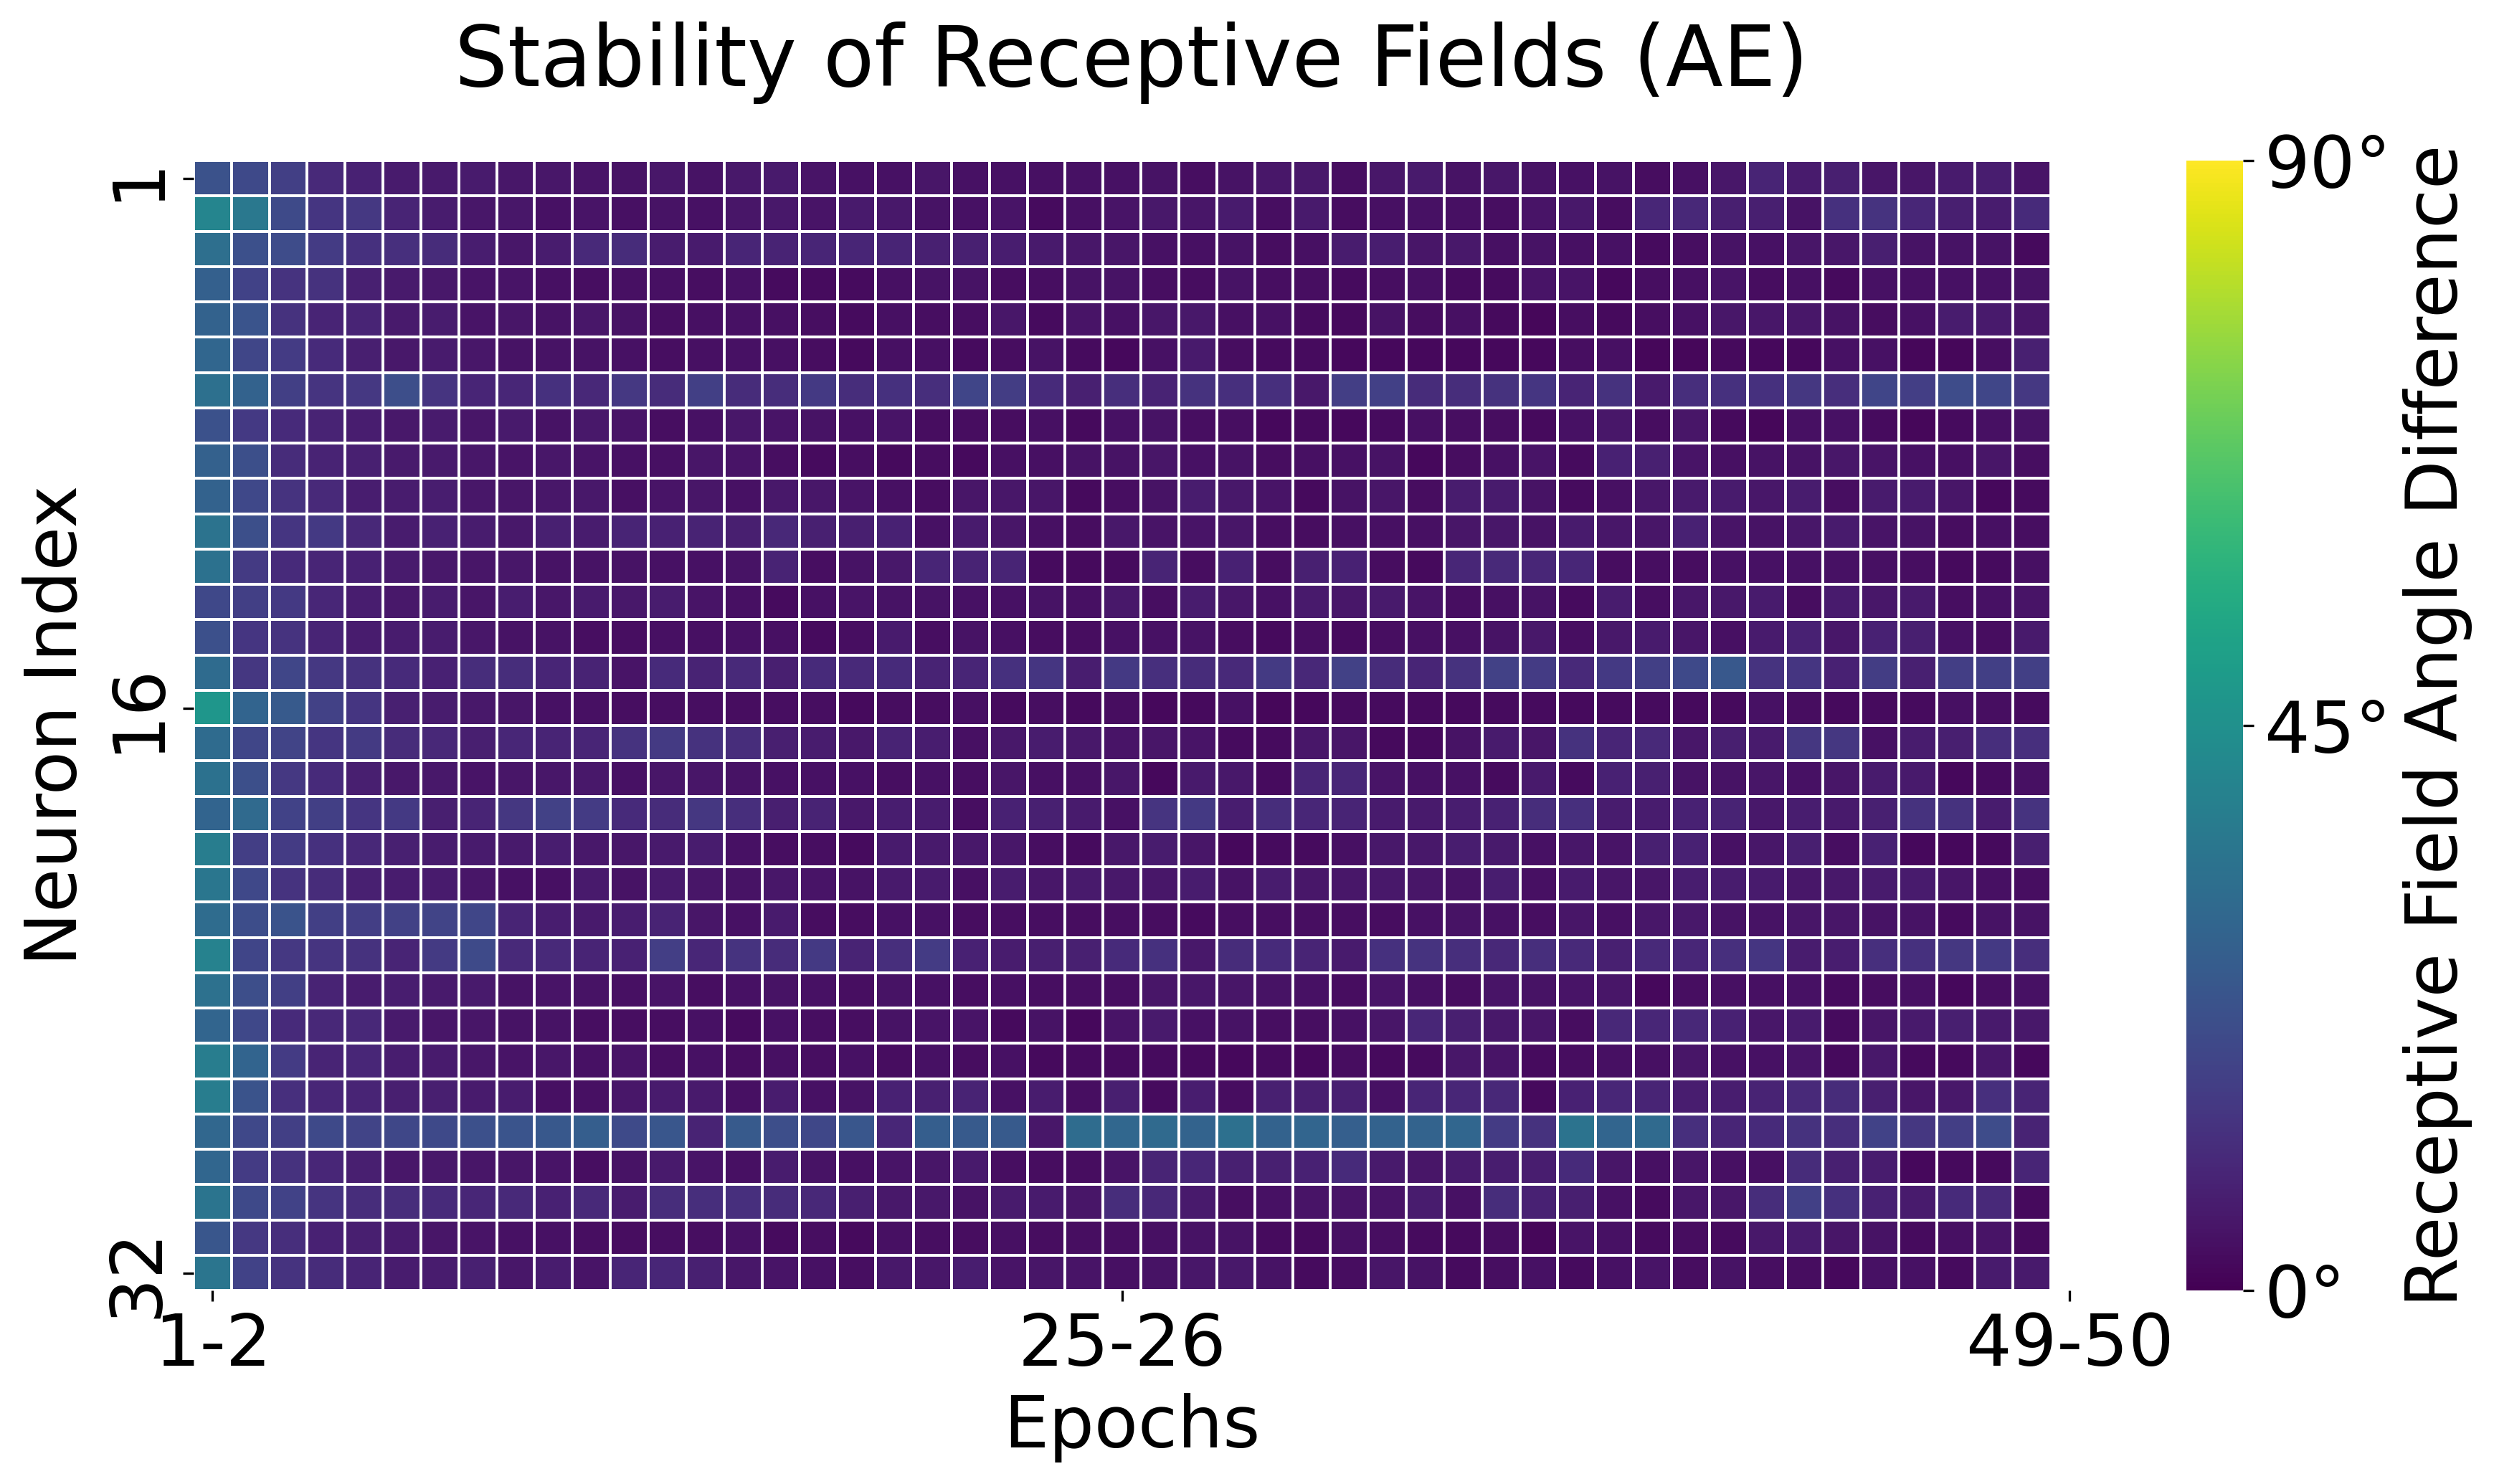

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    sae_average_angles[:, :50],
    cmap="viridis",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("Receptive Field Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

ax.set_title("Stability of Receptive Fields (AE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Neuron Index", fontsize=24)

plt.tight_layout()
plt.show()

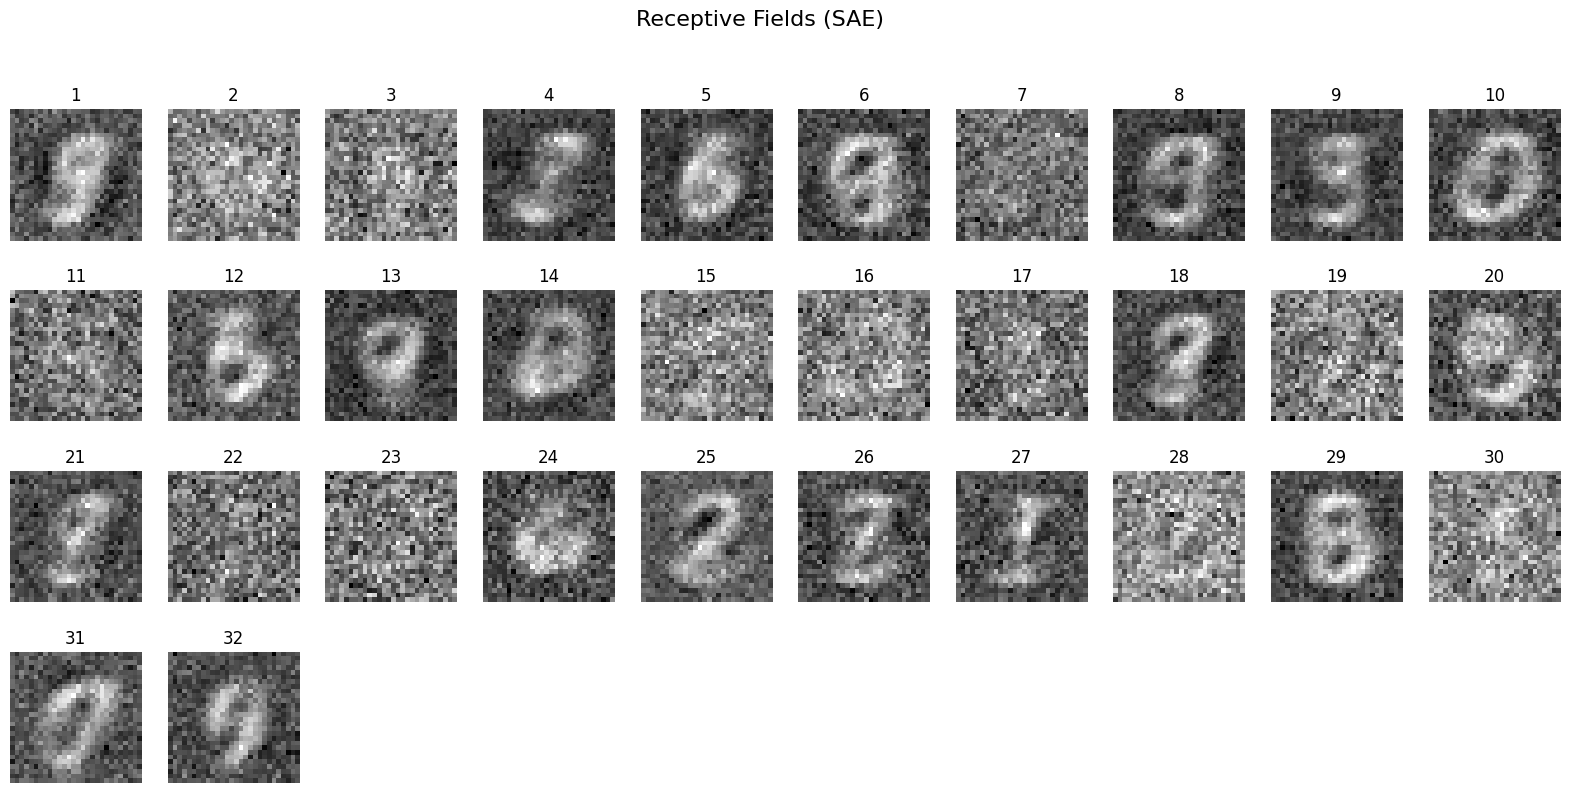

In [104]:
fig = plt.figure(figsize=(20,9))
fig.suptitle("Receptive Fields (SAE)", fontsize=16)
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.axis('off')
    plt.imshow(sae_rf_matrices[0][0][i].reshape(28,28),cmap='gray')

In [ ]:
# Generate frame for each epoch
filenames = []
for x in range(50):
    fig = plt.figure(figsize=(20, 9))
    fig.suptitle(f"Receptive Fields (SAE) - Step {x}", fontsize=16)
    
    for i in range(32):
        plt.subplot(4, 10, i+1)
        plt.title(str(i+1))
        plt.axis('off')
        plt.imshow(sae_rf_matrices[0][x][i].reshape(28, 28), cmap='gray')
    
    # Save frame
    filename = f'frame_{x:03d}.png'
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    filenames.append(filename)

# Create GIF
with imageio.get_writer('receptive_fields.gif', mode='I', duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove temporary PNG files
for filename in filenames:
    os.remove(filename)

/tmp/ipykernel_39280/944777997.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [41]:
test_array = np.array([1, 2, 3, 4])
print(np.pad(test_array, (0, 32-len(test_array)), 'constant', constant_values=0).shape)

(32,)


In [13]:
def activations_over_epochs(model_name, iteration, test_images=test_images, num_epochs=50):
    activations = np.full((32, num_epochs), np.nan)
    for epoch in tqdm(range(num_epochs)):
        model = load_model(f'/home/david/mnist_model/{model_name}/{iteration}/', model_name, epoch)

        encodings = []

        for j in range(len(test_images)):
            encodings.append(model.encode(torch.tensor(test_images[j]).view(1, -1).float()).detach().numpy())

        encodings = np.mean(encodings, axis=0).squeeze()
        encodings = np.pad(encodings, (0, 32 - len(encodings)), 'constant', constant_values=np.nan)
        activations[:, epoch] = encodings
    return np.array(activations).squeeze()

In [18]:
dae_encodings = activations_over_epochs('dae', 1, test_images=test_images, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torc

In [16]:
def activations_heatmap(activations, model):
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

    heatmap = sns.heatmap(
        activations[:, :50],
        cmap="inferno",
        vmin=0,
        vmax=10,
        cbar_kws={"label": "Angle between PCs"},
        linewidths=0.5,
    )

    cbar = heatmap.collections[0].colorbar
    # cbar.set_ticks([0, 45, 90])
    # cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
    cbar.set_label("Strength of Activation", fontsize=24)
    cbar.minorticks_off()

    ax.set_xticks([0.5, 24.5, 49.5])
    ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

    ax.set_yticks([0.5, 15.5, 31.5])
    ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

    ax.set_title(f"Neuron Activation over Epochs ({model})", fontsize=28, pad=25)
    ax.set_xlabel("Epochs", fontsize=24)
    ax.set_ylabel("Neuron Index", fontsize=24)

    plt.tight_layout()
    plt.show()

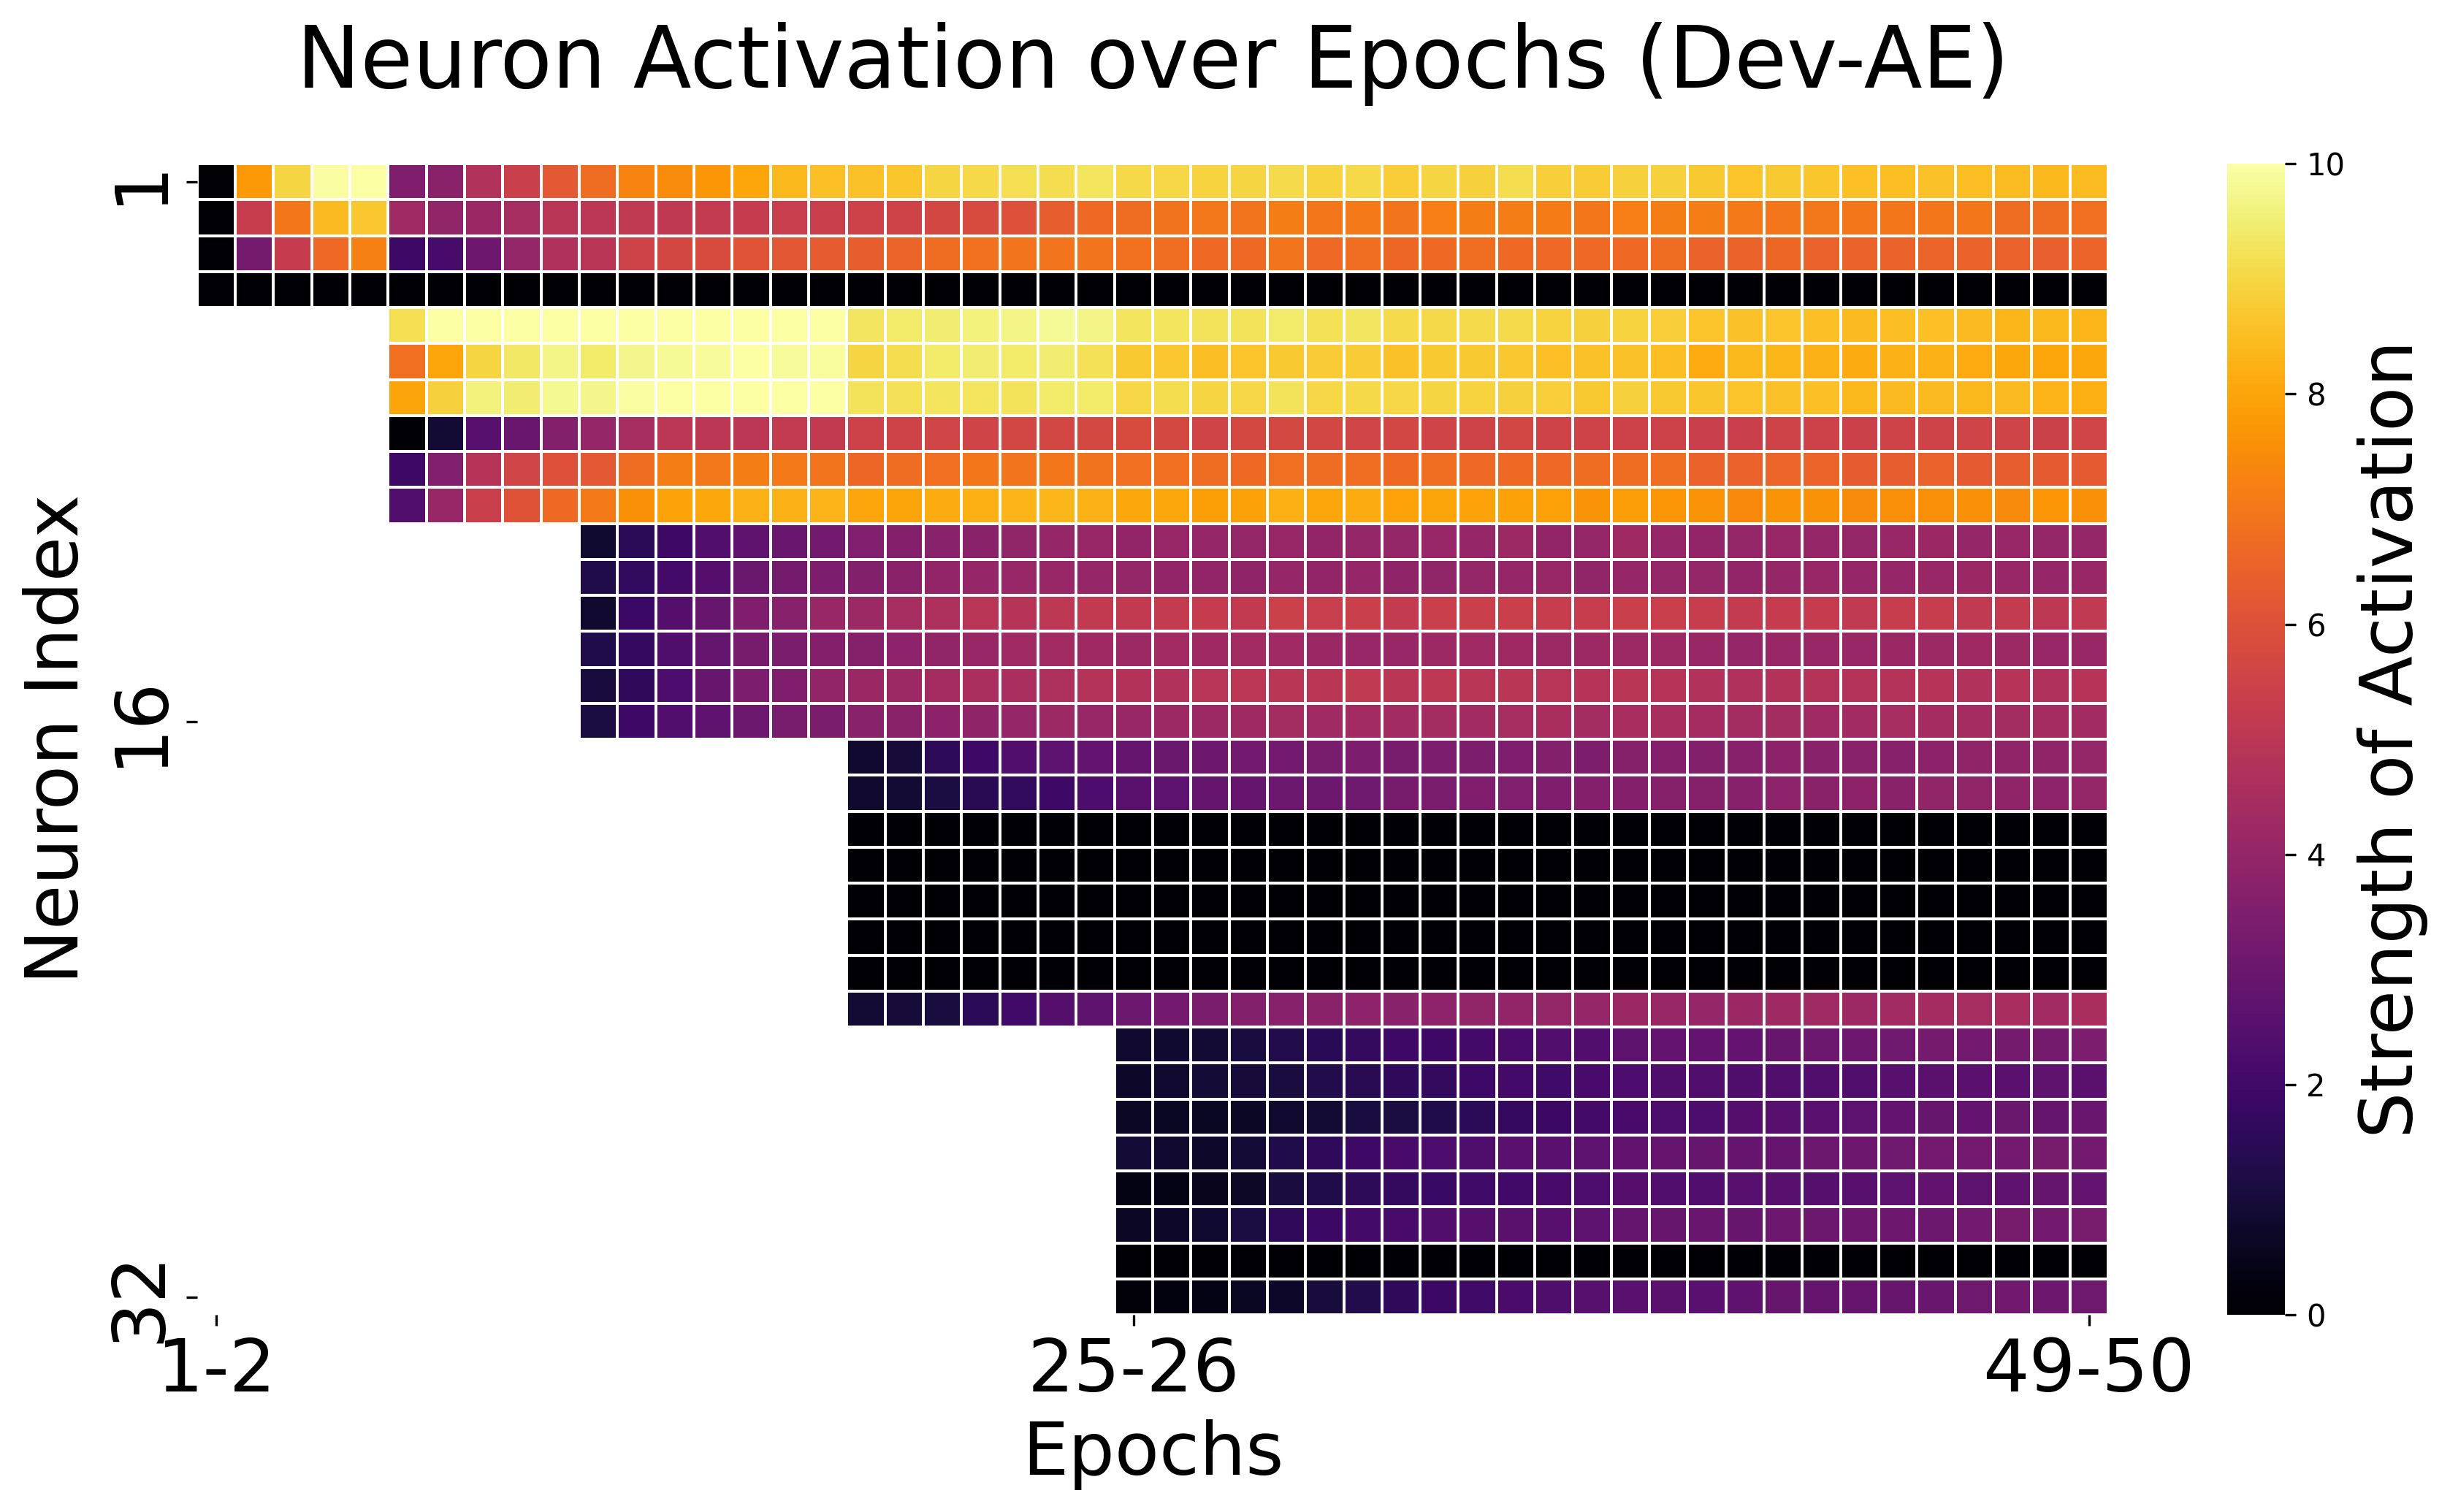

In [19]:
activations_heatmap(dae_encodings, 'Dev-AE')

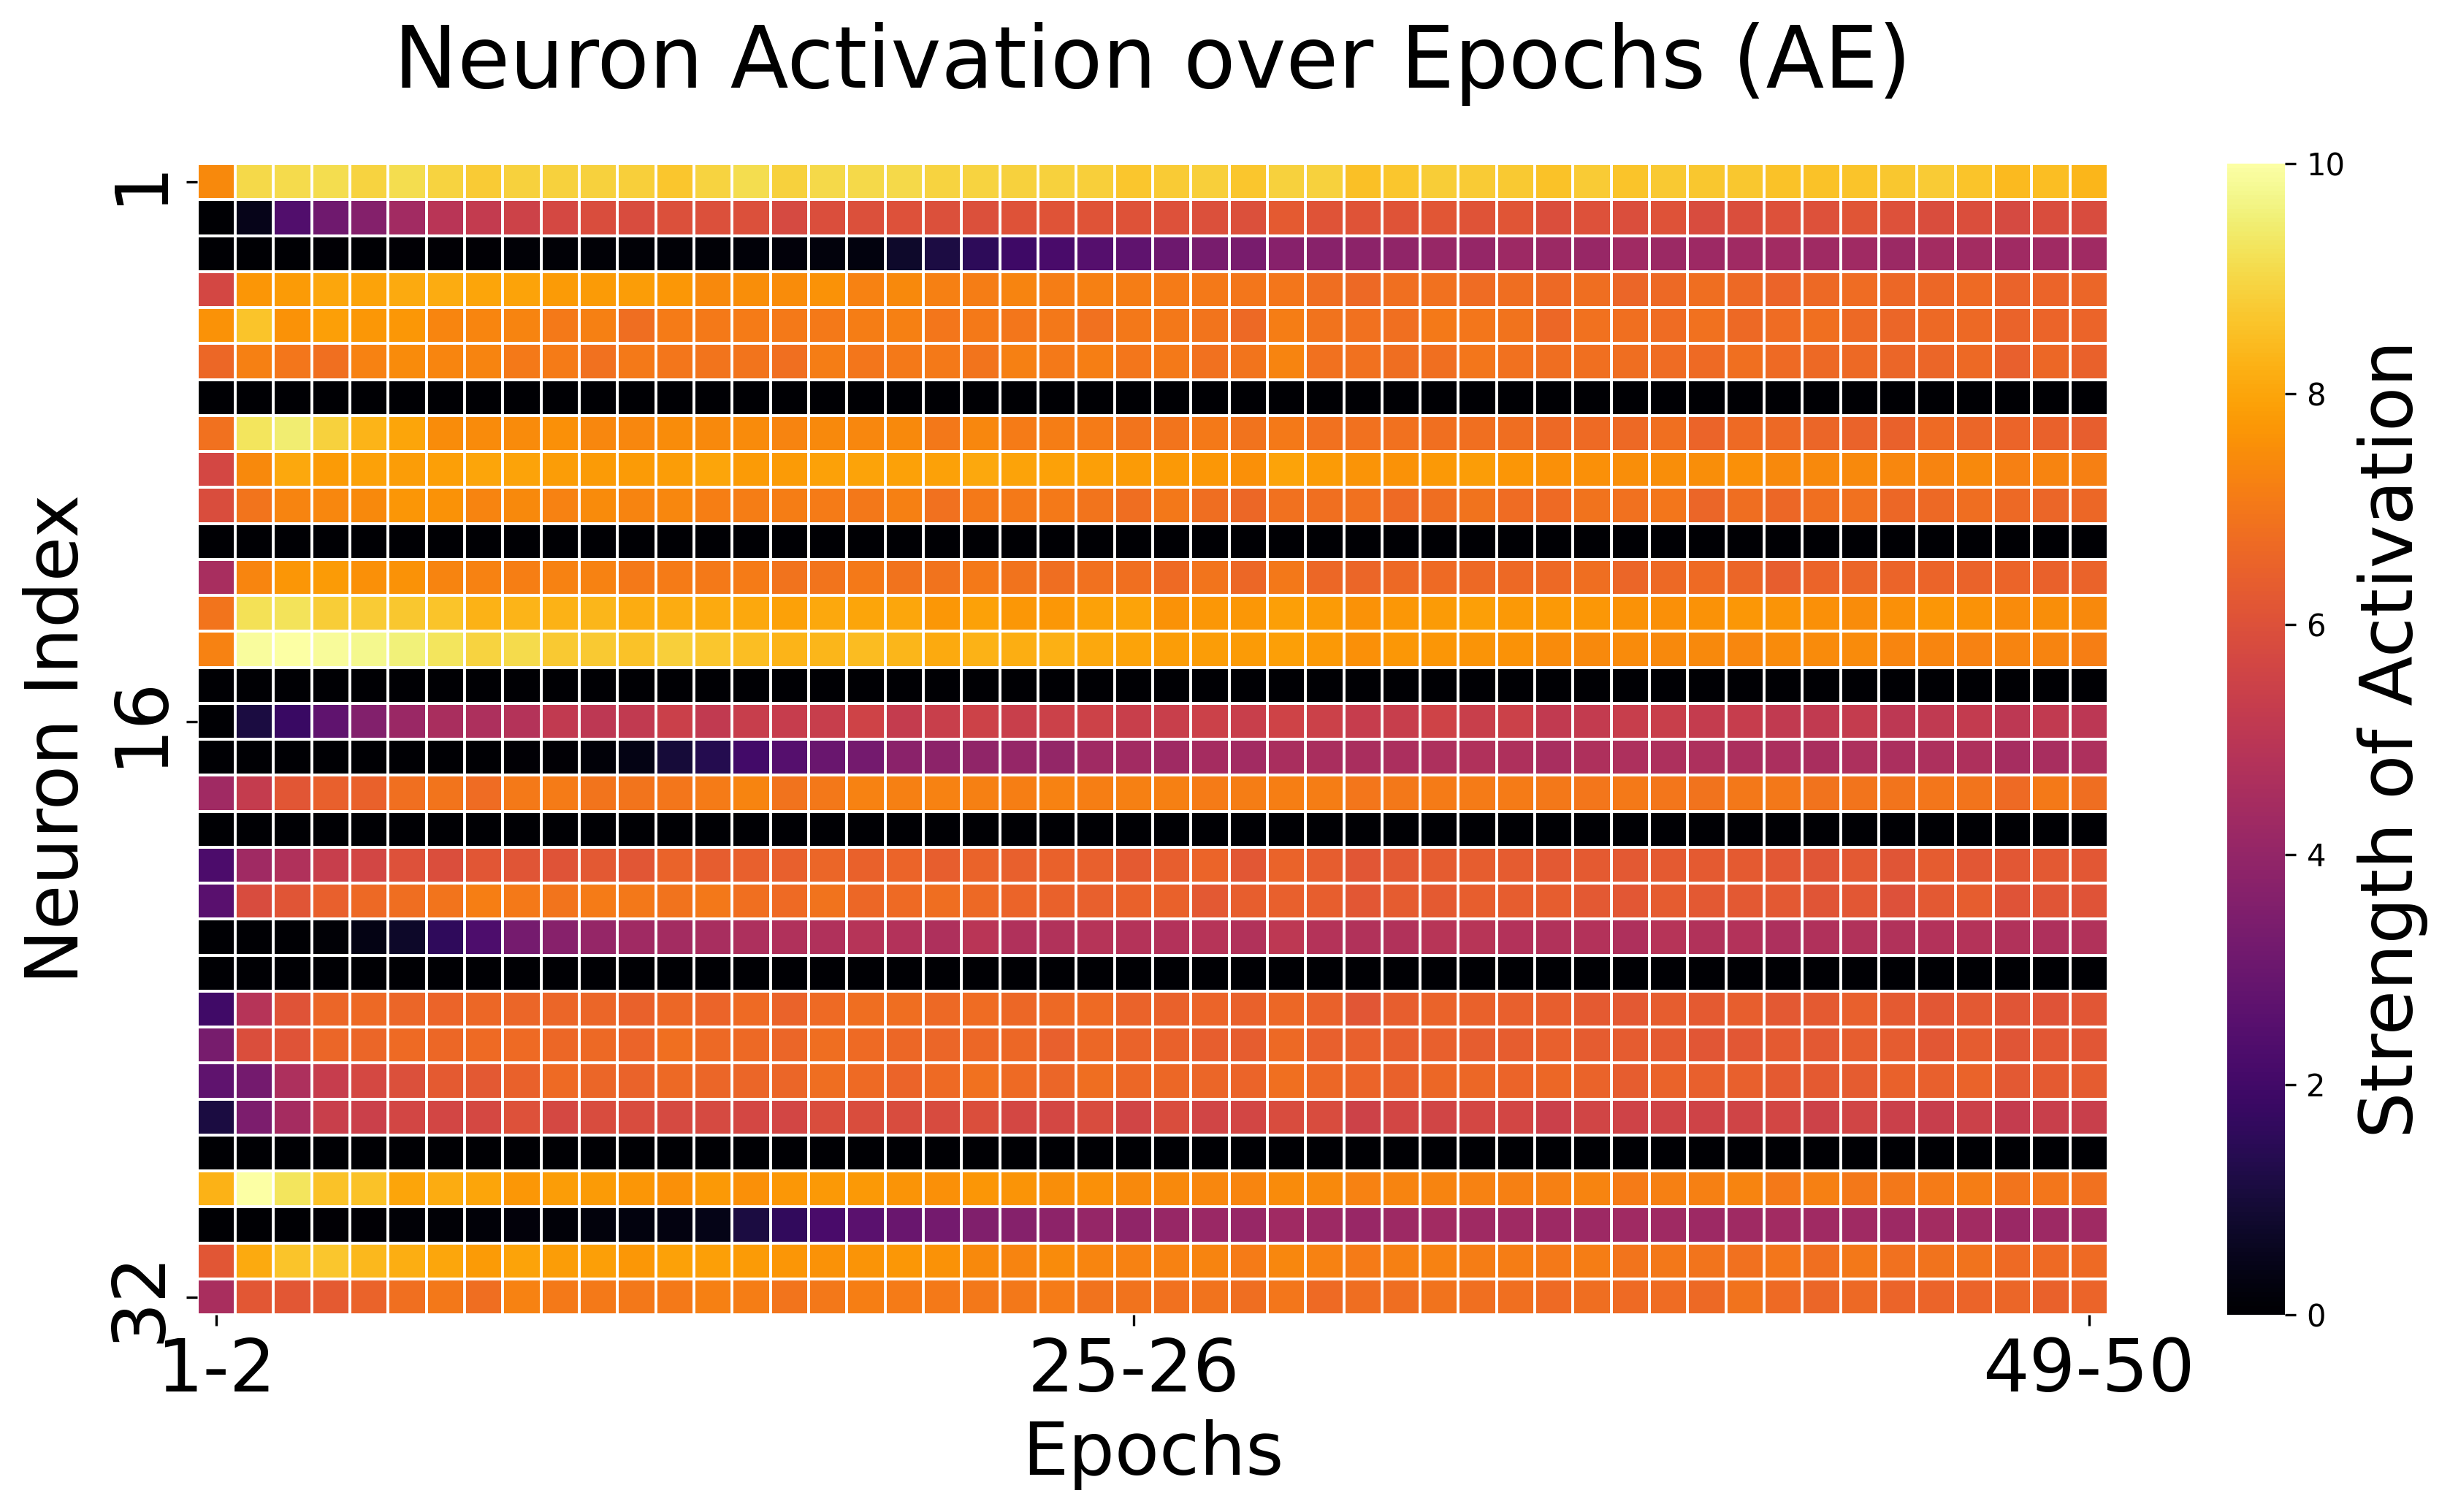

In [ ]:
def activations_heatmap(activations, model):
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

    heatmap = sns.heatmap(
        activations[:, :50],
        cmap="inferno",
        vmin=0,
        vmax=10,
        cbar_kws={"label": "Angle between PCs"},
        linewidths=0.5,
    )

    cbar = heatmap.collections[0].colorbar
    # cbar.set_ticks([0, 45, 90])
    # cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
    cbar.set_label("Strength of Activation", fontsize=24)
    cbar.minorticks_off()

    ax.set_xticks([0.5, 24.5, 49.5])
    ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

    ax.set_yticks([0.5, 15.5, 31.5])
    ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

    ax.set_title(f"Neuron Activation over Epochs ({model})", fontsize=28, pad=25)
    ax.set_xlabel("Epochs", fontsize=24)
    ax.set_ylabel("Neuron Index", fontsize=24)

    plt.tight_layout()
    plt.show()

### Compare DAE Model with static bottleneck to SAE

In [68]:
def train_dae(save_path):
    dae_model = NonLinearAutoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
    dae_optimizer = torch.optim.SGD(dae_model.parameters(), lr=0.1, momentum=0.9)

    size_ls = (
                [32] * 50
    )

    manner = 'cell_division'

    dae_train_loss, dae_validation_loss = nl_dev_train_vali_all_epochs(
        dae_model, 
        size_ls,
        manner,
        train_loader,
        validation_loader, 
        dae_optimizer, 
        n_epochs=50,
        device=torch.device('cpu'), 
        save_path=save_path+'/'
        )
    
    return dae_model, dae_train_loss, dae_validation_loss

In [69]:
save_path = '/home/david/mnist_model/test_model/dae_with_32_neurons2'
train_dae(save_path)

Directory created: /home/david/mnist_model/test_model/dae_with_32_neurons2/
[32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
 32 32]
32


Train Epoch: 0 [47872/48000 (100%)]	Loss: 0.007828: 100%|██████████| 375/375 [00:03<00:00, 98.43it/s] 

====> Epoch: 0 Average loss: 1.0016



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:390: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 1.0004
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.6110
====> Test set loss: 0.4272
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 2 [47872/48000 (100%)]	Loss: 0.002497: 100%|██████████| 375/375 [00:03<00:00, 106.26it/s]

====> Epoch: 2 Average loss: 0.3689


====> Test set loss: 0.3119
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 3 [47872/48000 (100%)]	Loss: 0.002095: 100%|██████████| 375/375 [00:03<00:00, 111.11it/s]

====> Epoch: 3 Average loss: 0.2846


====> Test set loss: 0.2636
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 4 [47872/48000 (100%)]	Loss: 0.001910: 100%|██████████| 375/375 [00:03<00:00, 104.62it/s]

====> Epoch: 4 Average loss: 0.2459


====> Test set loss: 0.2318
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 5 [47872/48000 (100%)]	Loss: 0.001659: 100%|██████████| 375/375 [00:03<00:00, 96.47it/s]

====> Epoch: 5 Average loss: 0.2220


====> Test set loss: 0.2162
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 6 [47872/48000 (100%)]	Loss: 0.001625: 100%|██████████| 375/375 [00:04<00:00, 90.43it/s]

====> Epoch: 6 Average loss: 0.2080


====> Test set loss: 0.2041
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 7 [47872/48000 (100%)]	Loss: 0.001583: 100%|██████████| 375/375 [00:04<00:00, 91.09it/s]

====> Epoch: 7 Average loss: 0.1979


====> Test set loss: 0.1942
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 8 [47872/48000 (100%)]	Loss: 0.001413: 100%|██████████| 375/375 [00:04<00:00, 91.01it/s]

====> Epoch: 8 Average loss: 0.1895


====> Test set loss: 0.1868
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 9 [47872/48000 (100%)]	Loss: 0.001482: 100%|██████████| 375/375 [00:03<00:00, 95.15it/s]

====> Epoch: 9 Average loss: 0.1816


====> Test set loss: 0.1812
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 10 [47872/48000 (100%)]	Loss: 0.001314: 100%|██████████| 375/375 [00:04<00:00, 93.04it/s]

====> Epoch: 10 Average loss: 0.1737


====> Test set loss: 0.1720
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 11 [47872/48000 (100%)]	Loss: 0.001278: 100%|██████████| 375/375 [00:04<00:00, 89.94it/s]

====> Epoch: 11 Average loss: 0.1672


====> Test set loss: 0.1660
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 12 [47872/48000 (100%)]	Loss: 0.001184: 100%|██████████| 375/375 [00:04<00:00, 90.13it/s]

====> Epoch: 12 Average loss: 0.1619


====> Test set loss: 0.1610
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 13 [47872/48000 (100%)]	Loss: 0.001170: 100%|██████████| 375/375 [00:04<00:00, 87.98it/s]

====> Epoch: 13 Average loss: 0.1573


====> Test set loss: 0.1583
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 14 [47872/48000 (100%)]	Loss: 0.001126: 100%|██████████| 375/375 [00:04<00:00, 89.61it/s]

====> Epoch: 14 Average loss: 0.1532


====> Test set loss: 0.1542
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 15 [47872/48000 (100%)]	Loss: 0.001215: 100%|██████████| 375/375 [00:04<00:00, 90.04it/s]

====> Epoch: 15 Average loss: 0.1497


====> Test set loss: 0.1501
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 16 [47872/48000 (100%)]	Loss: 0.001103: 100%|██████████| 375/375 [00:04<00:00, 90.97it/s]

====> Epoch: 16 Average loss: 0.1464


====> Test set loss: 0.1466
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 17 [47872/48000 (100%)]	Loss: 0.001019: 100%|██████████| 375/375 [00:04<00:00, 92.08it/s]

====> Epoch: 17 Average loss: 0.1436


====> Test set loss: 0.1440
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 18 [47872/48000 (100%)]	Loss: 0.001047: 100%|██████████| 375/375 [00:04<00:00, 92.34it/s]

====> Epoch: 18 Average loss: 0.1410


====> Test set loss: 0.1421
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 19 [47872/48000 (100%)]	Loss: 0.001047: 100%|██████████| 375/375 [00:04<00:00, 93.62it/s] 


====> Epoch: 19 Average loss: 0.1387
====> Test set loss: 0.1387
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 20 [47872/48000 (100%)]	Loss: 0.000970: 100%|██████████| 375/375 [00:04<00:00, 90.49it/s]

====> Epoch: 20 Average loss: 0.1366


====> Test set loss: 0.1378
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 21 [47872/48000 (100%)]	Loss: 0.000957: 100%|██████████| 375/375 [00:03<00:00, 94.48it/s]

====> Epoch: 21 Average loss: 0.1345


====> Test set loss: 0.1356
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 22 [47872/48000 (100%)]	Loss: 0.000985: 100%|██████████| 375/375 [00:03<00:00, 95.73it/s]

====> Epoch: 22 Average loss: 0.1323


====> Test set loss: 0.1330
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 23 [47872/48000 (100%)]	Loss: 0.001032: 100%|██████████| 375/375 [00:03<00:00, 95.13it/s]

====> Epoch: 23 Average loss: 0.1302


====> Test set loss: 0.1319
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 24 [47872/48000 (100%)]	Loss: 0.000987: 100%|██████████| 375/375 [00:03<00:00, 95.11it/s] 

====> Epoch: 24 Average loss: 0.1287


====> Test set loss: 0.1310
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 25 [47872/48000 (100%)]	Loss: 0.001070: 100%|██████████| 375/375 [00:03<00:00, 96.13it/s] 

====> Epoch: 25 Average loss: 0.1269


====> Test set loss: 0.1283
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 26 [47872/48000 (100%)]	Loss: 0.000982: 100%|██████████| 375/375 [00:03<00:00, 93.78it/s]

====> Epoch: 26 Average loss: 0.1256


====> Test set loss: 0.1269
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 27 [47872/48000 (100%)]	Loss: 0.000993: 100%|██████████| 375/375 [00:04<00:00, 91.77it/s]

====> Epoch: 27 Average loss: 0.1241


====> Test set loss: 0.1264
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 28 [47872/48000 (100%)]	Loss: 0.000966: 100%|██████████| 375/375 [00:03<00:00, 105.27it/s]

====> Epoch: 28 Average loss: 0.1229


====> Test set loss: 0.1250
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 29 [47872/48000 (100%)]	Loss: 0.000921: 100%|██████████| 375/375 [00:03<00:00, 103.17it/s]

====> Epoch: 29 Average loss: 0.1215


====> Test set loss: 0.1230
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 30 [47872/48000 (100%)]	Loss: 0.000941: 100%|██████████| 375/375 [00:03<00:00, 94.40it/s]

====> Epoch: 30 Average loss: 0.1202


====> Test set loss: 0.1217
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 31 [47872/48000 (100%)]	Loss: 0.000953: 100%|██████████| 375/375 [00:04<00:00, 93.03it/s] 

====> Epoch: 31 Average loss: 0.1188


====> Test set loss: 0.1200
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 32 [47872/48000 (100%)]	Loss: 0.000868: 100%|██████████| 375/375 [00:03<00:00, 96.54it/s] 

====> Epoch: 32 Average loss: 0.1174


====> Test set loss: 0.1204
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 33 [47872/48000 (100%)]	Loss: 0.000875: 100%|██████████| 375/375 [00:03<00:00, 97.54it/s] 


====> Epoch: 33 Average loss: 0.1164
====> Test set loss: 0.1181
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 34 [47872/48000 (100%)]	Loss: 0.000899: 100%|██████████| 375/375 [00:03<00:00, 97.54it/s] 


====> Epoch: 34 Average loss: 0.1153
====> Test set loss: 0.1170
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 35 [47872/48000 (100%)]	Loss: 0.000932: 100%|██████████| 375/375 [00:04<00:00, 91.60it/s]

====> Epoch: 35 Average loss: 0.1143


====> Test set loss: 0.1165
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 36 [47872/48000 (100%)]	Loss: 0.000884: 100%|██████████| 375/375 [00:03<00:00, 94.97it/s]

====> Epoch: 36 Average loss: 0.1135


====> Test set loss: 0.1150
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 37 [47872/48000 (100%)]	Loss: 0.000810: 100%|██████████| 375/375 [00:03<00:00, 95.90it/s] 

====> Epoch: 37 Average loss: 0.1123


====> Test set loss: 0.1153
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 38 [47872/48000 (100%)]	Loss: 0.000881: 100%|██████████| 375/375 [00:03<00:00, 95.61it/s] 

====> Epoch: 38 Average loss: 0.1117


====> Test set loss: 0.1141
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 39 [47872/48000 (100%)]	Loss: 0.000871: 100%|██████████| 375/375 [00:03<00:00, 96.50it/s] 

====> Epoch: 39 Average loss: 0.1109


====> Test set loss: 0.1140
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 40 [47872/48000 (100%)]	Loss: 0.000888: 100%|██████████| 375/375 [00:04<00:00, 93.01it/s]

====> Epoch: 40 Average loss: 0.1103


====> Test set loss: 0.1122
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 41 [47872/48000 (100%)]	Loss: 0.000941: 100%|██████████| 375/375 [00:04<00:00, 92.17it/s] 

====> Epoch: 41 Average loss: 0.1096


====> Test set loss: 0.1121
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 42 [47872/48000 (100%)]	Loss: 0.000873: 100%|██████████| 375/375 [00:03<00:00, 95.60it/s] 

====> Epoch: 42 Average loss: 0.1087


====> Test set loss: 0.1117
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 43 [47872/48000 (100%)]	Loss: 0.000872: 100%|██████████| 375/375 [00:03<00:00, 93.96it/s]

====> Epoch: 43 Average loss: 0.1082


====> Test set loss: 0.1107
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 44 [47872/48000 (100%)]	Loss: 0.000863: 100%|██████████| 375/375 [00:03<00:00, 95.34it/s]

====> Epoch: 44 Average loss: 0.1076


====> Test set loss: 0.1100
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 45 [47872/48000 (100%)]	Loss: 0.000792: 100%|██████████| 375/375 [00:03<00:00, 96.93it/s]

====> Epoch: 45 Average loss: 0.1070


====> Test set loss: 0.1097
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 46 [47872/48000 (100%)]	Loss: 0.000792: 100%|██████████| 375/375 [00:04<00:00, 90.80it/s]

====> Epoch: 46 Average loss: 0.1066


====> Test set loss: 0.1094
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 47 [47872/48000 (100%)]	Loss: 0.000843: 100%|██████████| 375/375 [00:04<00:00, 92.31it/s]

====> Epoch: 47 Average loss: 0.1060


====> Test set loss: 0.1084
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 48 [47872/48000 (100%)]	Loss: 0.000809: 100%|██████████| 375/375 [00:04<00:00, 88.28it/s]


====> Epoch: 48 Average loss: 0.1054
====> Test set loss: 0.1081
Weights saved.
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 49 [47872/48000 (100%)]	Loss: 0.000780: 100%|██████████| 375/375 [00:04<00:00, 81.85it/s]


====> Epoch: 49 Average loss: 0.1050
====> Test set loss: 0.1080
Weights saved.
All train losses saved.


(NonLinearAutoencoder(
   (encoder): Sequential(
     (encoder_1): Linear(in_features=784, out_features=512, bias=True)
     (activation_1): ReLU()
     (encoder_2): Linear(in_features=512, out_features=128, bias=True)
     (activation_2): ReLU()
     (encoder_3): Linear(in_features=128, out_features=32, bias=True)
     (activation_3): ReLU()
   )
   (decoder): Sequential(
     (decoder_1): Linear(in_features=32, out_features=128, bias=True)
     (activation_1): ReLU()
     (decoder_2): Linear(in_features=128, out_features=512, bias=True)
     (activation_2): ReLU()
     (decoder_3): Linear(in_features=512, out_features=784, bias=True)
   )
 ),
 [1.0015975211461385,
  0.6109852256774903,
  0.36892330463727313,
  0.28462112812201185,
  0.24593066231409708,
  0.22195490634441375,
  0.20799051423867543,
  0.1978709876537323,
  0.1894866387049357,
  0.1815653123855591,
  0.17368558462460837,
  0.16721906014283497,
  0.16189932636419932,
  0.15732003978888193,
  0.15319002691904704,
  0.149

In [70]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = ([32]*50)
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'sae' or model_type == 'SAE':
        model = NonLinearAutoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = NonLinearAutoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [71]:
# For all different models
dae_like_sae_rf_matrices = []

for iteration in range(1):
    # For all different epochs
    dae_like_sae_rf_matrix = []
    
    for epoch in tqdm(range(50)):
        data = torch.randn(28, 28)
        data = data.unsqueeze(0)
        input = data.view(data.size(0), -1)
        input.requires_grad_(True)

        dae = load_model(save_path, 'dae', epoch)
        
        layer_name = 'bottle_neck'
        dae_activation_dictionary = {}

        dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

        dae_rf_ls = []
        for i in range(32):
            output = amu.act_max(network=dae,
                            input=input,
                            layer_activation=dae_activation_dictionary,
                            layer_name=layer_name,
                            unit=i,
                            steps=steps,
                            alpha=alpha,
                            verbose=verbose,
                            L2_Decay=L2_Decay,
                            Gaussian_Blur=Gaussian_Blur,
                            Norm_Crop=Norm_Crop,
                            Contrib_Crop=Contrib_Crop,
                            )
            dae_rf_ls.append(output.detach().numpy())
        dae_rf_ls = np.array(dae_rf_ls).squeeze()

        dae_like_sae_rf_matrix.append(dae_rf_ls)

    dae_like_sae_rf_matrices.append(dae_like_sae_rf_matrix)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_39280/508578385.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_e

In [72]:
num_models = 1
num_epochs = 50
num_neurons = 32

dae_like_sae_angles_matrix = np.zeros((num_models, num_neurons, num_epochs-1))

for model in range(num_models):
    for epoch in range(num_epochs-1):
        for neuron in range(num_neurons):
            angle = cosine_angle_between_pcs(dae_like_sae_rf_matrices[model][epoch][neuron], dae_like_sae_rf_matrices[model][epoch + 1][neuron])
            dae_like_sae_angles_matrix[model, neuron, epoch] = angle

dae_like_sae_angles_matrix = np.array(dae_like_sae_angles_matrix)

dae_like_sae_average_angles = np.mean(dae_like_sae_angles_matrix, axis=0)

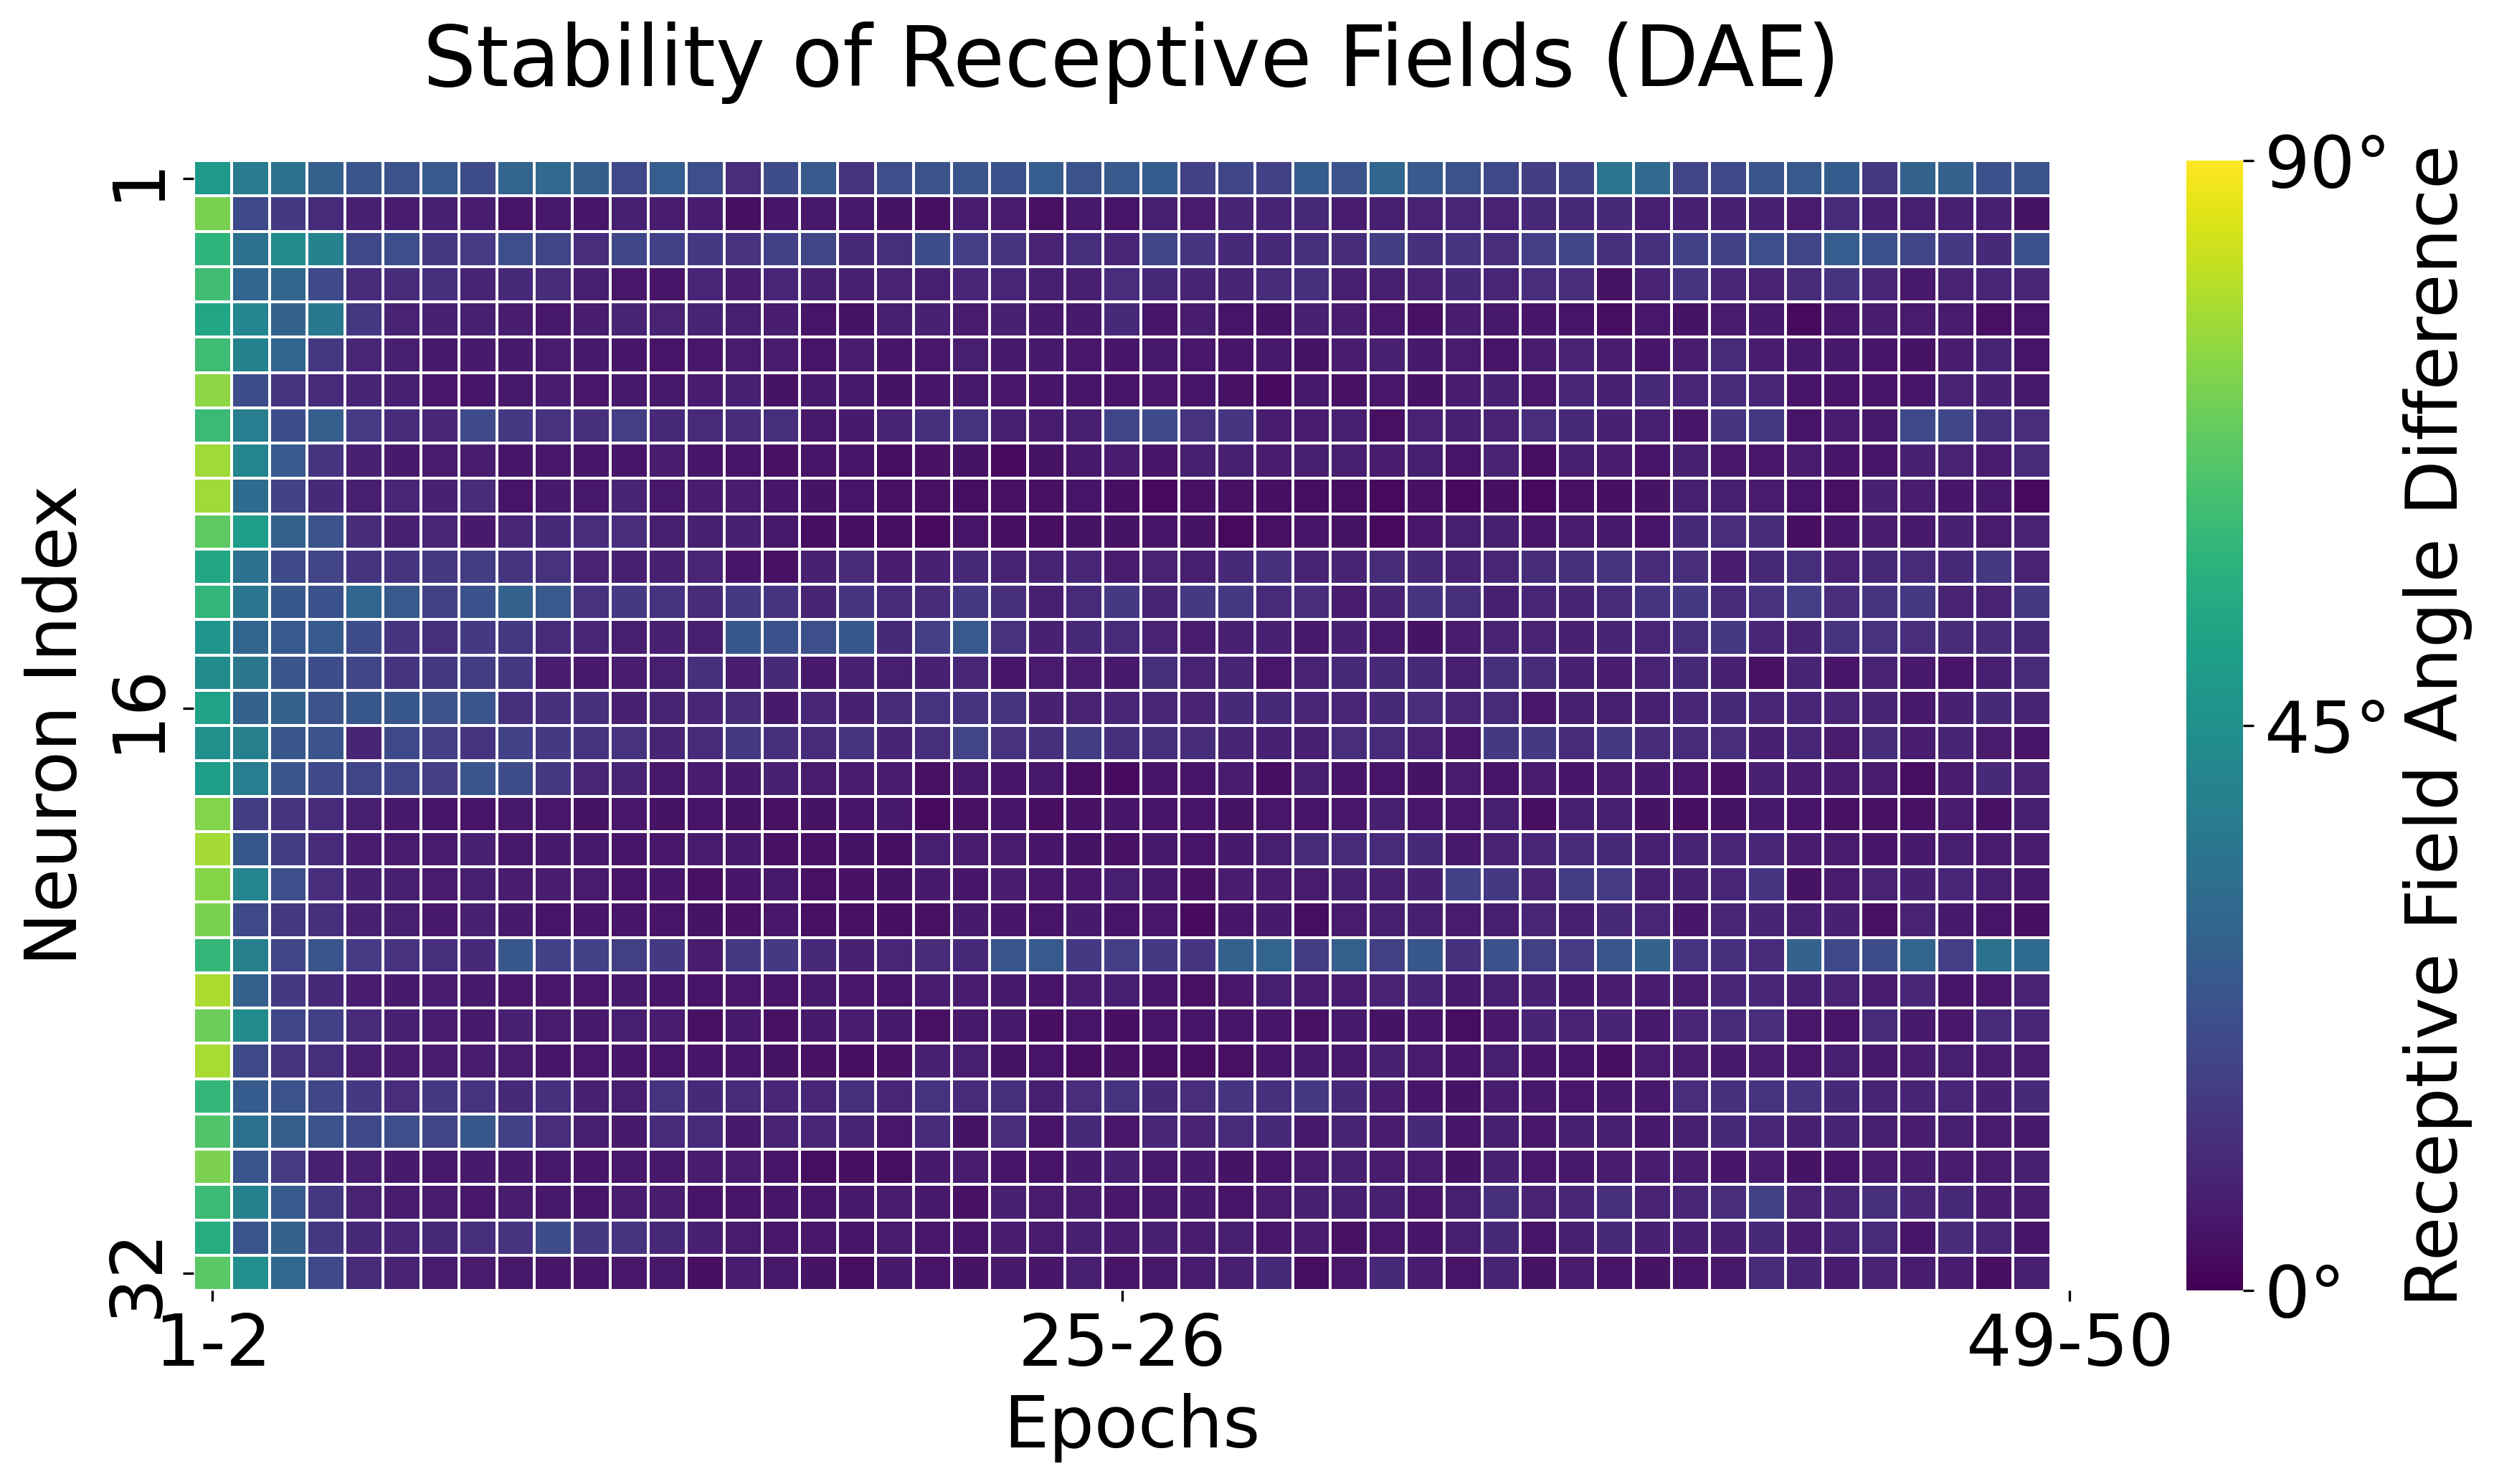

In [73]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    dae_like_sae_average_angles[:, :50],
    cmap="viridis",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("Receptive Field Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

ax.set_title("Stability of Receptive Fields (DAE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Neuron Index", fontsize=24)

plt.tight_layout()
plt.show()

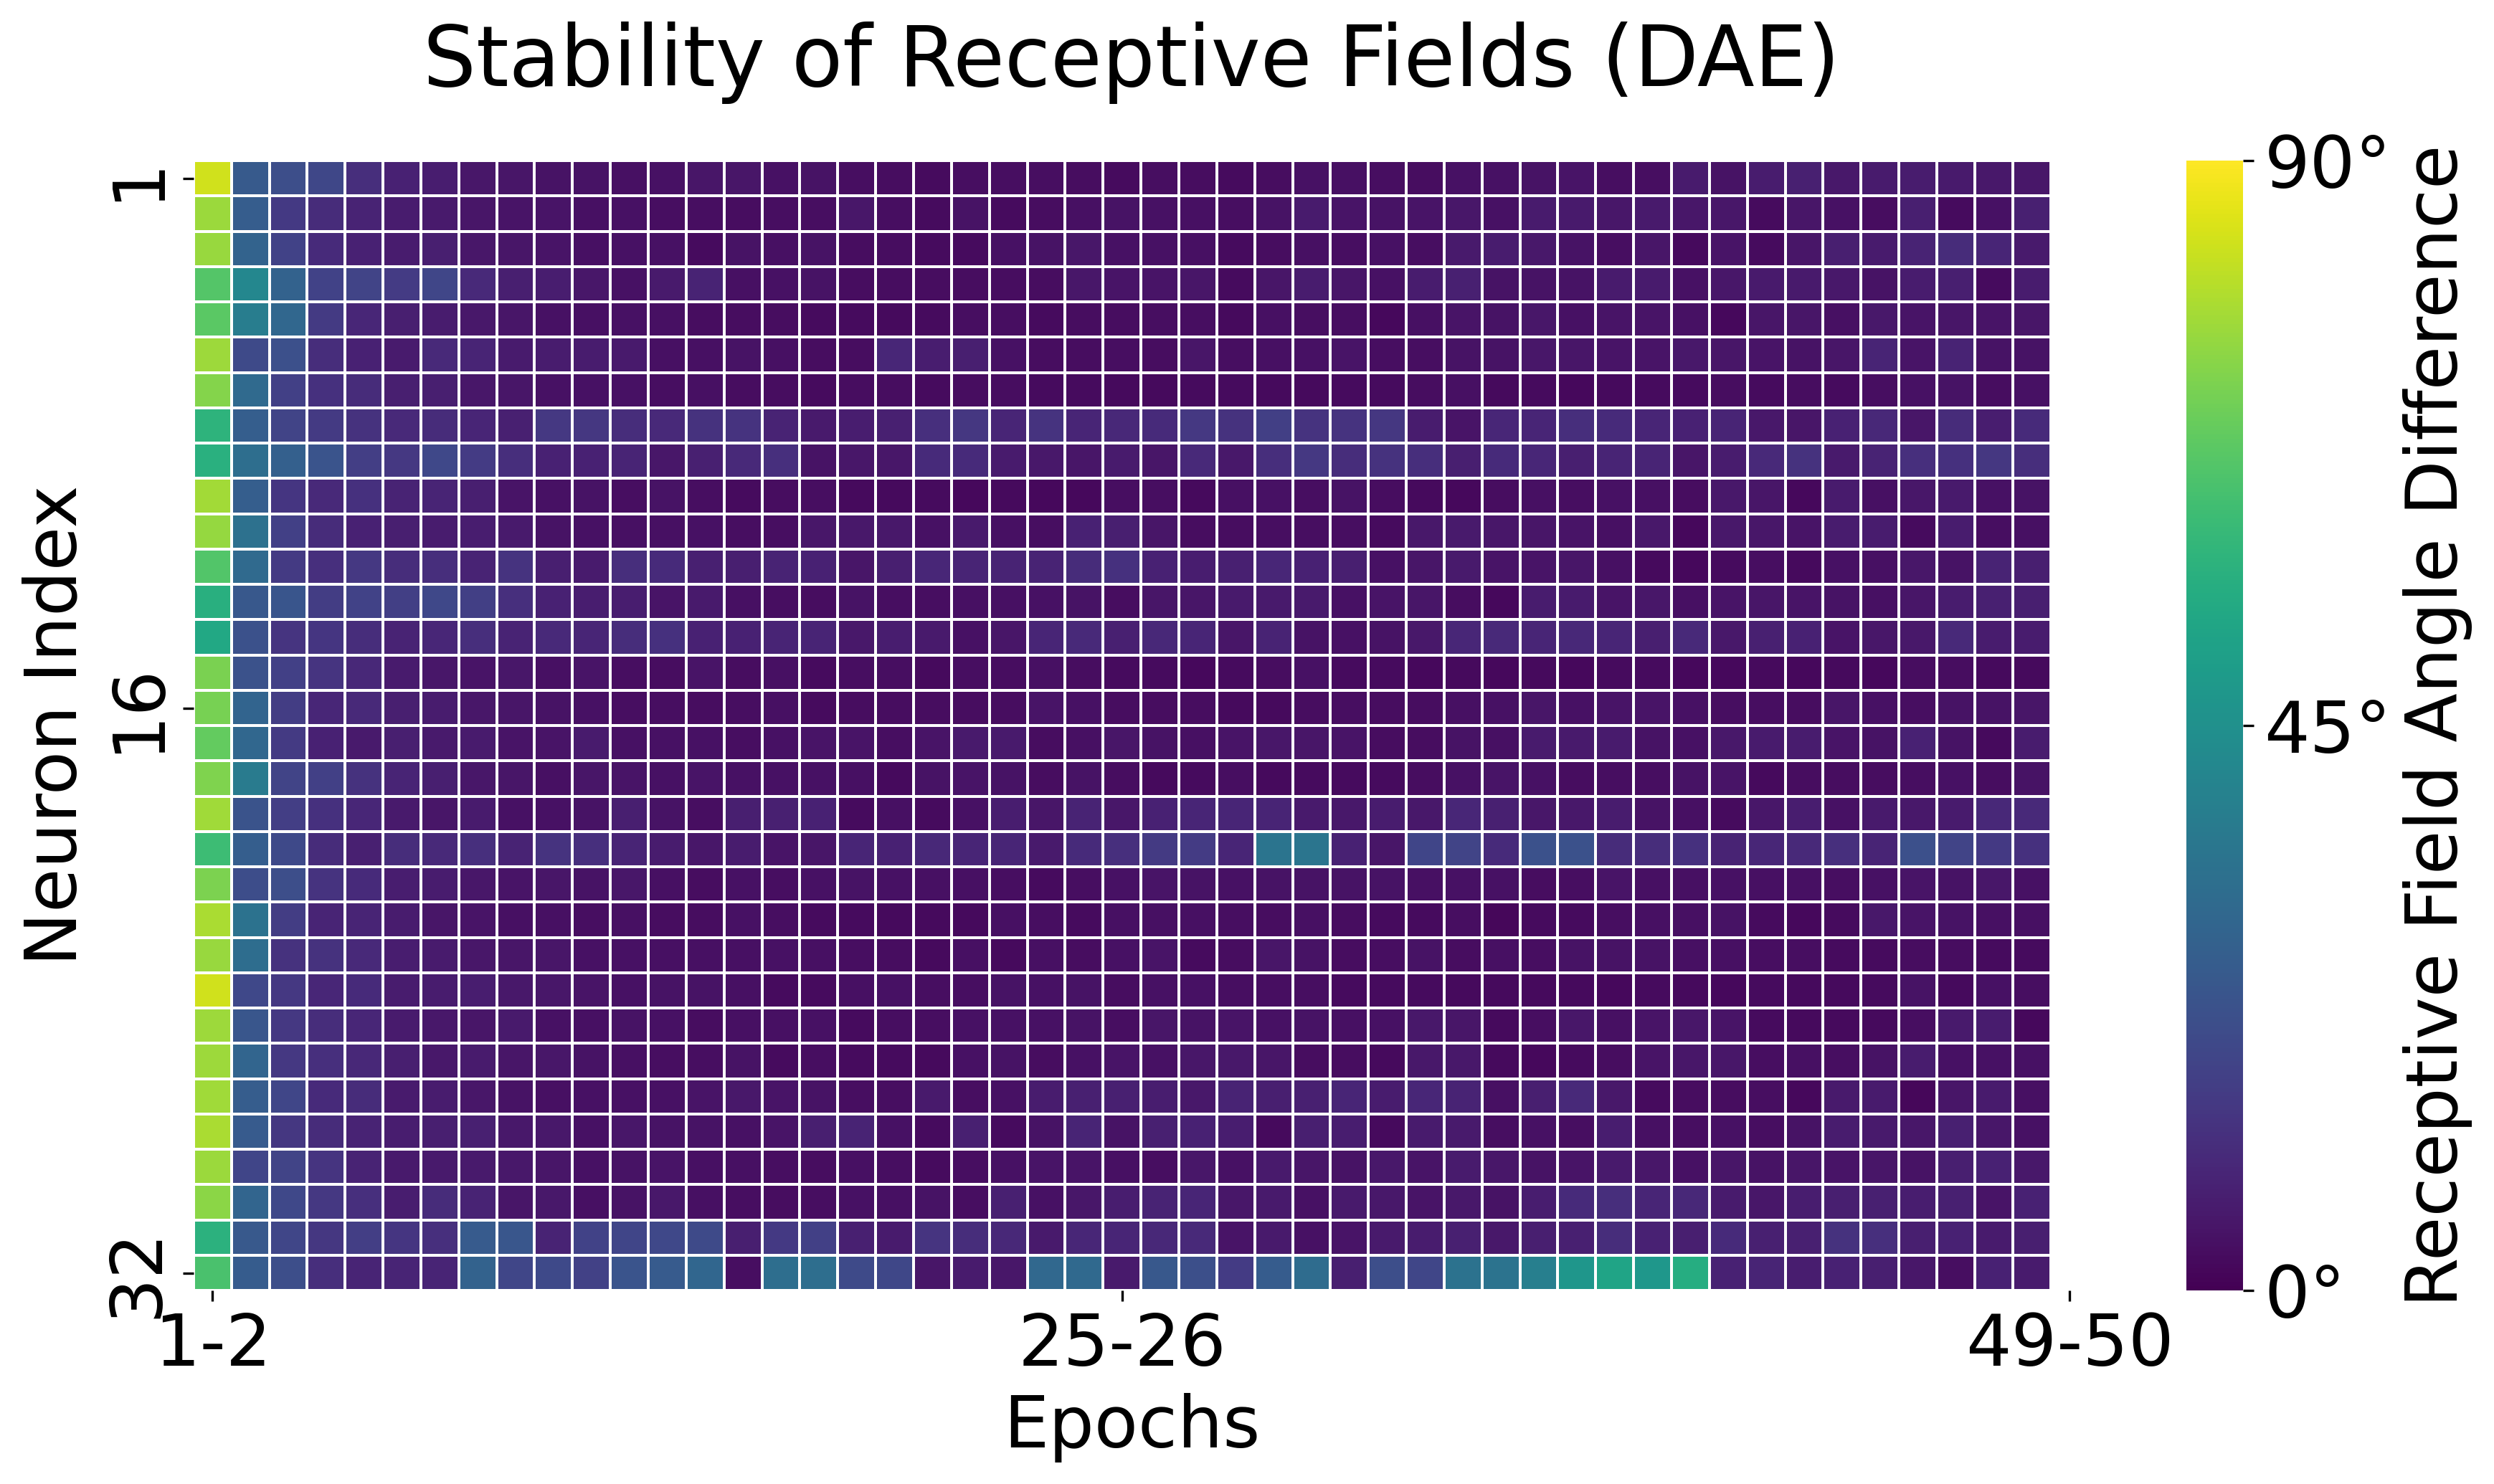

In [36]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    dae_like_sae_average_angles[:, :50],
    cmap="viridis",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("Receptive Field Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

ax.set_title("Stability of Receptive Fields (DAE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Neuron Index", fontsize=24)

plt.tight_layout()
plt.show()

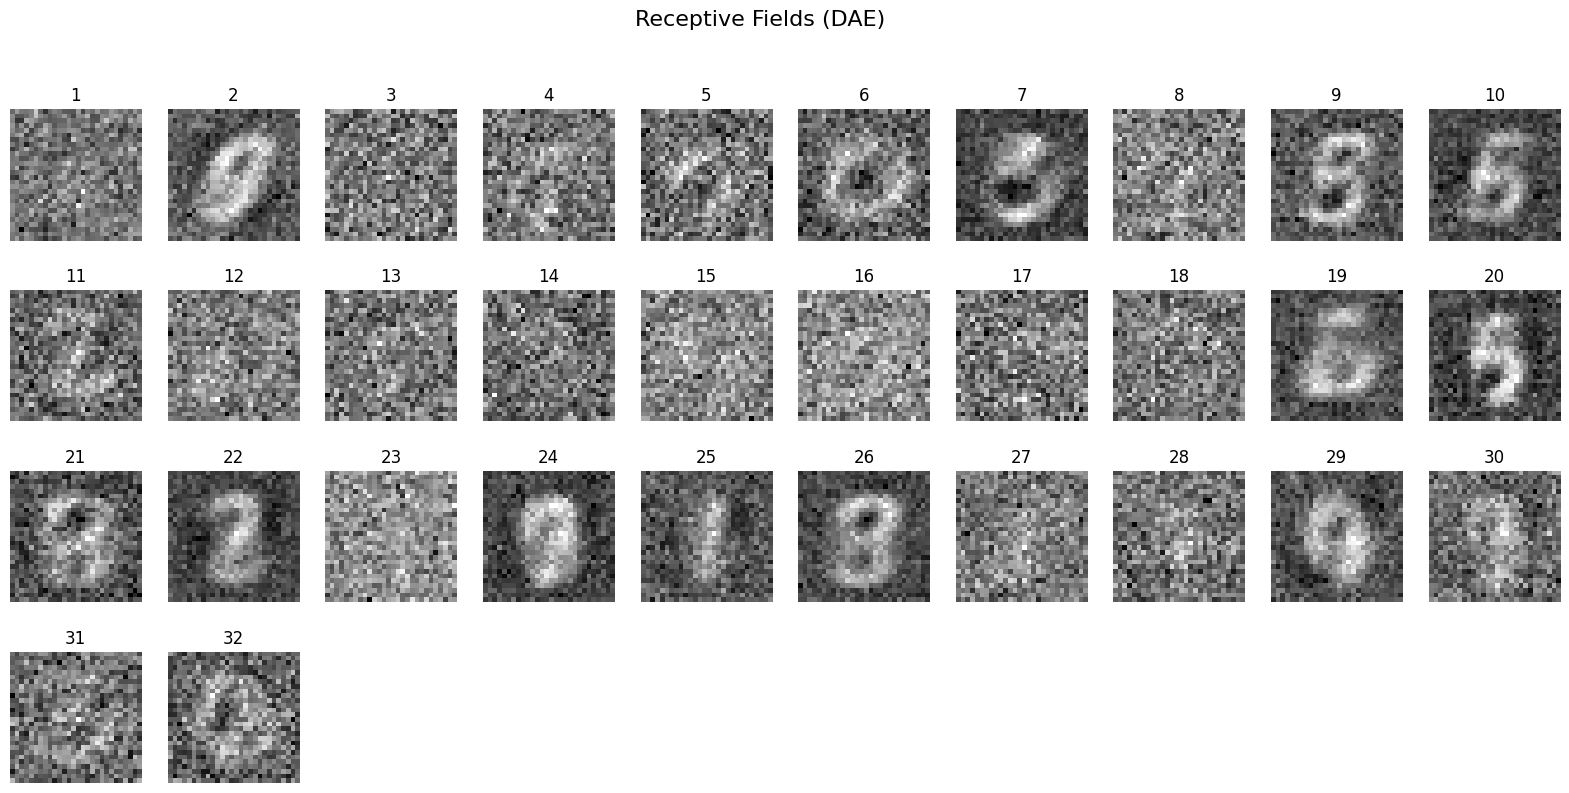

In [106]:
fig = plt.figure(figsize=(20,9))
fig.suptitle("Receptive Fields (DAE)", fontsize=16)
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.axis('off')
    plt.imshow(dae_like_sae_rf_matrices[0][1][i].reshape(28,28),cmap='gray')

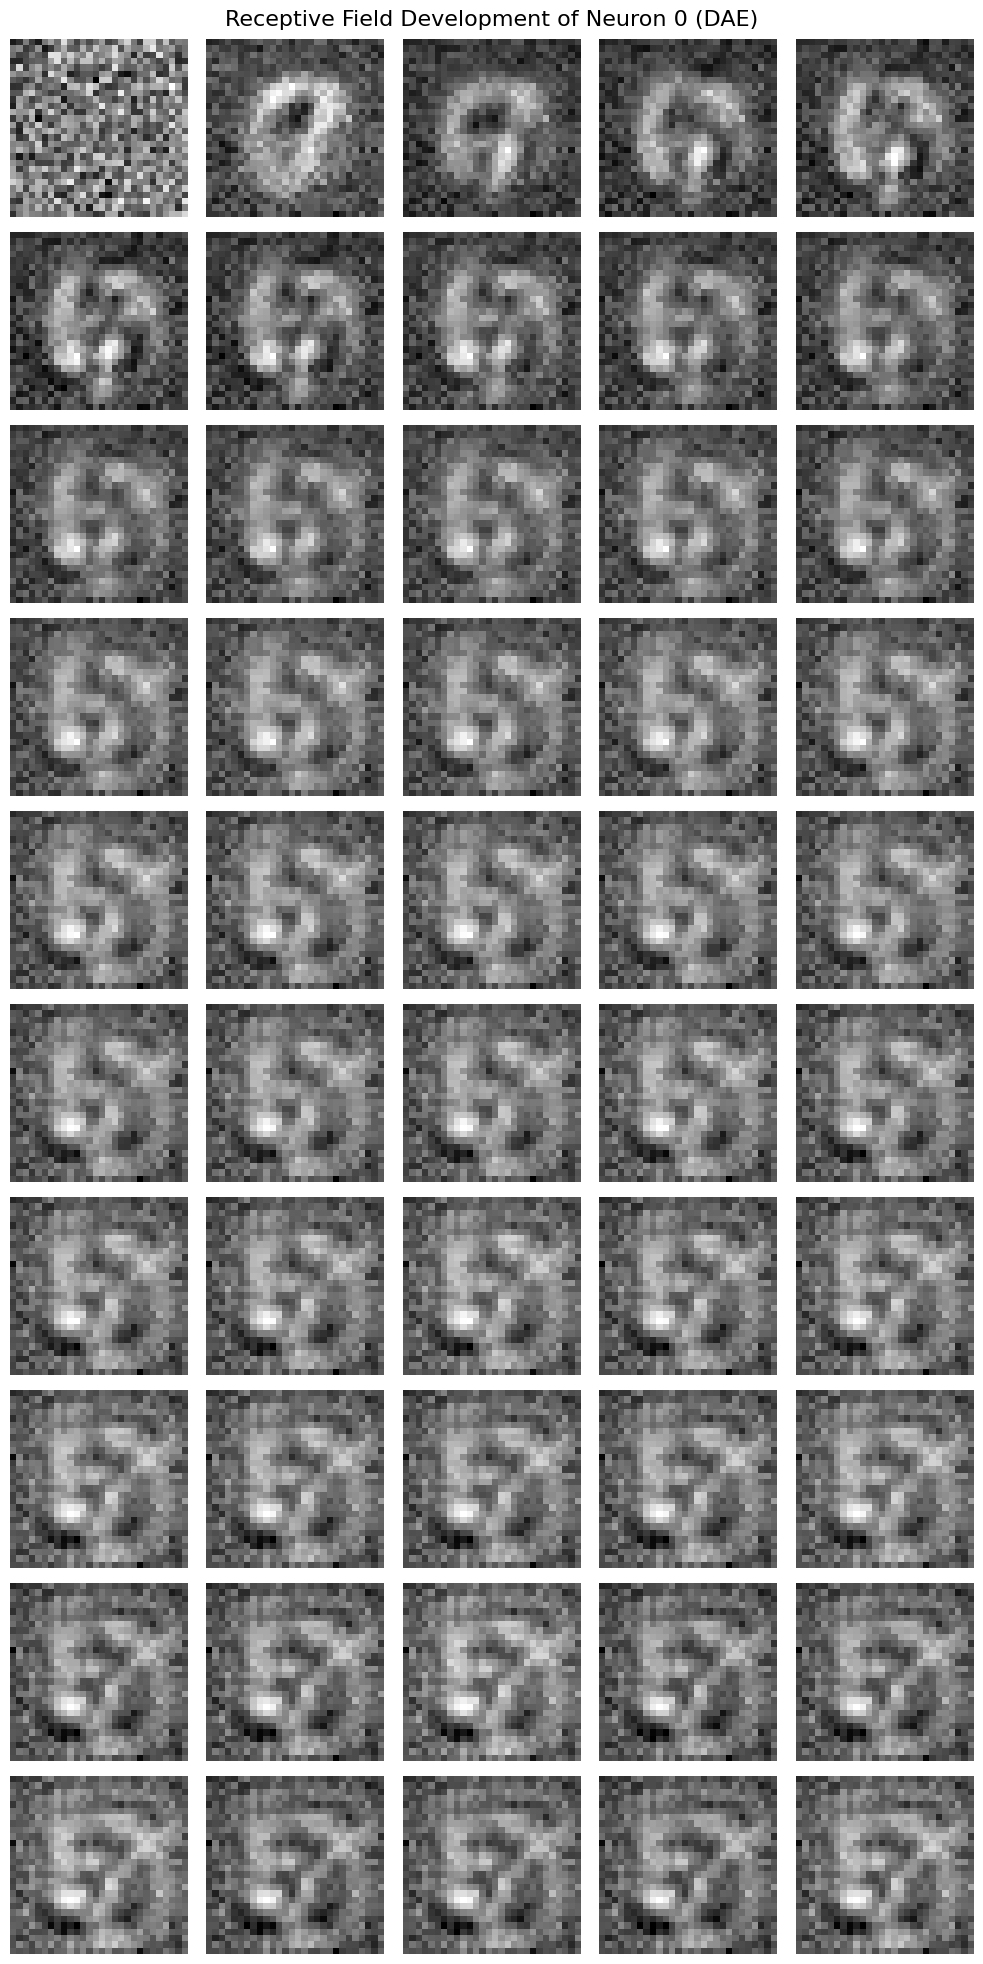

In [40]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
axes = axes.ravel()

for i in range(50):
    axes[i].imshow(dae_like_sae_rf_matrices[0][i][0].reshape(28, 28), cmap='binary_r')
    axes[i].axis('off')

fig.suptitle("Receptive Field Development of Neuron 0 (DAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

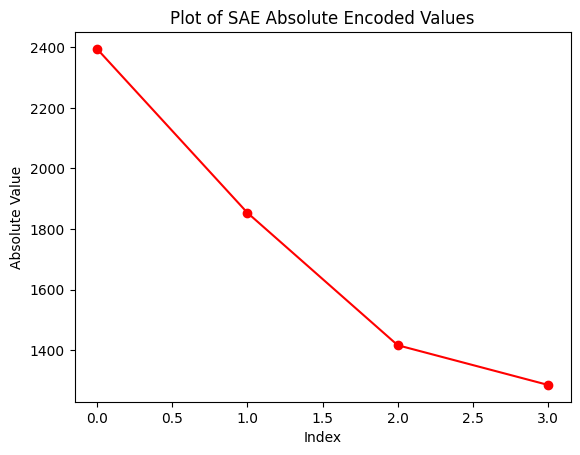

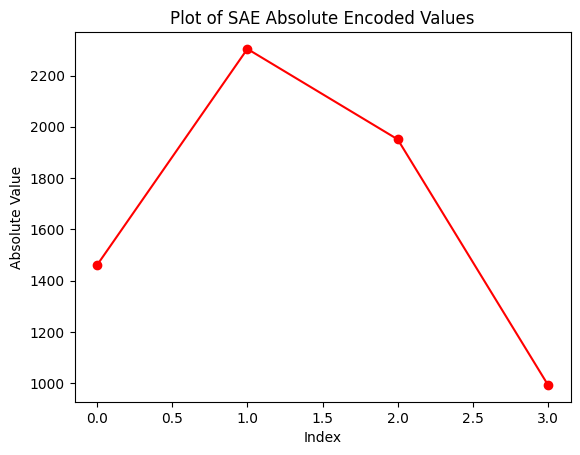

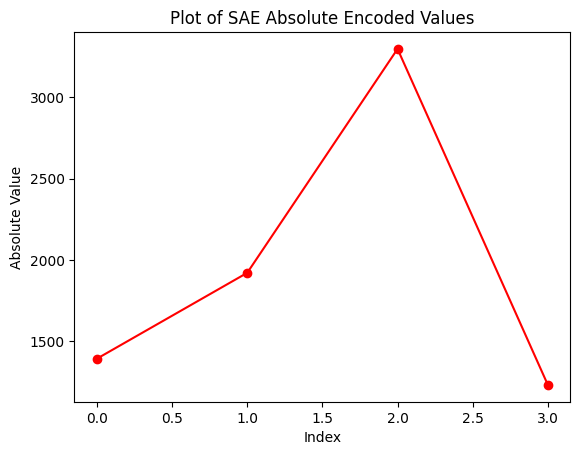

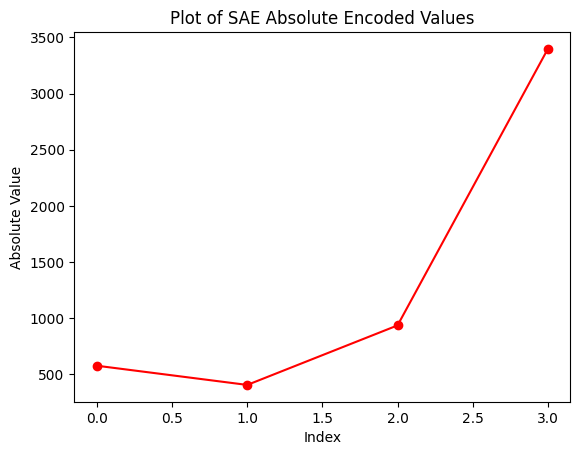

In [86]:
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
    for rf in sae_rf_ls:
        input = torch.tensor(rf).to('cpu')
        encoded, decoded = sae(input)
        sae_absolute_encoded = torch.abs(encoded)
        
        # Plotting the values
        plt.figure()
        plt.plot(range(len(sae_absolute_encoded)), sae_absolute_encoded.cpu().numpy(), marker='o', color='red')
        plt.xlabel('Index')
        plt.ylabel('Absolute Value')
        plt.title('Plot of SAE Absolute Encoded Values')
        plt.show()